In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import random
import torchaudio

random.seed(0)
np.random.seed(0)

In [2]:
!nvidia-smi

Wed Jul 19 21:47:22 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:01:00.0  On |                  N/A |
| 65%   69C    P3             159W / 350W |    489MiB / 24576MiB |      9%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Load GoEmotions and General Audio Datasets (CREMA, TESS,  RAVDASS, ETC)

In [3]:
train_audio = pkl.load(open('/home/vmachado/Documents/c4ai_clip_audio_text/data/c4ai_clip/train_audio.pkl', "rb"))[['path', 'label']]
test_audio = pkl.load(open('/home/vmachado/Documents/c4ai_clip_audio_text/data/c4ai_clip/test_audio.pkl', "rb"))[['path', 'label']]
train_text = pkl.load(open('/home/vmachado/Documents/c4ai_clip_audio_text/data/c4ai_clip/train_text.pkl', "rb"))[['text', 'grouped_label']]
test_text = pkl.load(open('/home/vmachado/Documents/c4ai_clip_audio_text/data/c4ai_clip/test_text.pkl', "rb"))[['text', 'grouped_label']]

In [4]:
go_emotions = pd.concat([train_text, test_text])

In [5]:
go_emotions.groupby("grouped_label").count()

text
grouped_label       
anger           6039
disgust          664
fear             705
joy            19002
neutral        14429
sadness         2936
surprise        5062

In [6]:
anger = go_emotions[go_emotions["grouped_label"] == "anger"].sample(5000, replace=False, random_state=0)
disgust = go_emotions[go_emotions["grouped_label"] == "disgust"].sample(4000, replace=True, random_state=0)
fear = go_emotions[go_emotions["grouped_label"] == "fear"].sample(4000, replace=True, random_state=0)
joy = go_emotions[go_emotions["grouped_label"] == "joy"].sample(5000, replace=False, random_state=0)
neutral = go_emotions[go_emotions["grouped_label"] == "neutral"].sample(5000, replace=False, random_state=0)
sadness = go_emotions[go_emotions["grouped_label"] == "sadness"].sample(2000, replace=True, random_state=0)

In [7]:
go_emotions = go_emotions[go_emotions["grouped_label"] != "anger"]
go_emotions = go_emotions[go_emotions["grouped_label"] != "joy"]
go_emotions = go_emotions[go_emotions["grouped_label"] != "neutral"]
go_emotions = pd.concat([go_emotions, anger, disgust, fear, joy, neutral, sadness])
go_emotions.groupby("grouped_label").count()

text
grouped_label      
anger          5000
disgust        4664
fear           4705
joy            5000
neutral        5000
sadness        4936
surprise       5062

In [8]:
def norm_labels(x):
    if x == "afraid":
        return "fear"
    elif x == "angry":
        return "anger"
    elif x == "disgusted":
        return "disgust"
    elif x == "sad":
        return "sadness"
    else:
        return x

In [9]:
train_audio["label"] = train_audio["label"].apply(norm_labels)
test_audio["label"] = test_audio["label"].apply(norm_labels)

In [10]:
pd.concat([train_audio,test_audio]).groupby("label").count()

path
label         
anger     1863
disgust   1863
fear      1863
joy       2055
neutral   1583
sadness   1863
surprise   592

In [11]:
audio_datasets = pd.concat([train_audio,test_audio]).reset_index(drop=True)

In [12]:
surprise = audio_datasets[audio_datasets["label"] == "surprise"].sample(2000, replace=True, random_state=0)
audio_datasets = audio_datasets[audio_datasets["label"] != "surprise"]
audio_datasets = pd.concat([audio_datasets, surprise]).reset_index(drop=True)
#audio_datasets

In [13]:
audio_datasets.groupby("label").count()

path
label         
anger     1863
disgust   1863
fear      1863
joy       2055
neutral   1583
sadness   1863
surprise  2000

## Load Meld and IEMOCAP

In [14]:
train_df_erc = pd.read_csv("train_text_df.csv", index_col=0).rename(columns={"utterance":"text"})
train_df_erc["path"] = train_df_erc["path"].apply(lambda x: '/home/vmachado/Documents/' + x)
train_df_erc

text     label  \
0      The only one I know still love his parents. [B...       joy   
1      The only one I know still love his parents. Ye...   neutral   
2      Oh it's not bad thing it's good thing. You kno...       joy   
3      You know it's nice here, the air is sweet. You...   sadness   
4      You're not sorry you came? Not sorry, no.  I c...   sadness   
...                                                  ...       ...   
13723  That would be no. Come on. It doesn't taste ba...   neutral   
13724  Come on. It doesn't taste bad. Yeah, it's kind...       joy   
13725  Yeah, it's kinda sweet, sorta like, uh... Cant...   neutral   
13726  Cantaloupe juice. Exactly. [BFR] You've tasted...  surprise   
13727  Exactly. You've tasted it? You've tasted it. [...   neutral   

                                                    path  
0      /home/vmachado/Documents/multimodal-datasets/I...  
1      /home/vmachado/Documents/multimodal-datasets/I...  
2      /home/vmachado/Documents/multimodal-datasets/I...  
3      /home/vmachado/Documents/multimodal-datasets/I...  
4      /home/vmachado/Documents/multimodal-datasets/I...  
...                                                  ...  
13723  /home/vmachado/Documents/multimodal-datasets/M...  
13724  /home/vmachado/Documents/multimodal-datasets/M...  
13725  /home/vmachado/Documents/multimodal-datasets/M...  
13726  /home/vmachado/Documents/multimodal-datasets/M...  
13727  /home/vmachado/Documents/multimodal-datasets/M...  

[13728 rows x 3 columns]

In [15]:
test_df_erc = pd.read_csv("test_text_df.csv", index_col=0).rename(columns={"utterance":"text"})
test_df_erc["path"] = test_df_erc["path"].apply(lambda x: '/home/vmachado/Documents/' + x)
test_df_erc

text    label  \
0      [BFR] Brian, I need help. [AFT] Babe, I don't...  sadness   
1     Brian, I need help. [BFR] Babe, I don't know w...  neutral   
2     Babe, I don't know what to tell you.  Don't gi...  neutral   
3     I wish I had some answers for you, babe.  I me...  neutral   
4     I went to school and I got my degree.  And I g...  neutral   
...                                                 ...      ...   
3846     Oh, it is. It isn't. [BFR] It is. [AFT] Isn't!  neutral   
3847               It isn't. It is. [BFR] Isn't! [AFT]     anger   
3848   [BFR] Yeah baby! [AFT] I’m really glad you gu...      joy   
3849  Yeah baby! [BFR] I’m really glad you guys are ...  neutral   
3850                                               Hey.  neutral   

                                                   path  
0     /home/vmachado/Documents/multimodal-datasets/I...  
1     /home/vmachado/Documents/multimodal-datasets/I...  
2     /home/vmachado/Documents/multimodal-datasets/I...  
3     /home/vmachado/Documents/multimodal-datasets/I...  
4     /home/vmachado/Documents/multimodal-datasets/I...  
...                                                 ...  
3846  /home/vmachado/Documents/multimodal-datasets/M...  
3847  /home/vmachado/Documents/multimodal-datasets/M...  
3848  /home/vmachado/Documents/multimodal-datasets/M...  
3849  /home/vmachado/Documents/multimodal-datasets/M...  
3850  /home/vmachado/Documents/multimodal-datasets/M...  

[3851 rows x 3 columns]

In [16]:
test_df_erc["source"] = test_df_erc["path"].apply(lambda x: "meld" if "MELD" in x else "iemocap")
test_df_erc

text    label  \
0      [BFR] Brian, I need help. [AFT] Babe, I don't...  sadness   
1     Brian, I need help. [BFR] Babe, I don't know w...  neutral   
2     Babe, I don't know what to tell you.  Don't gi...  neutral   
3     I wish I had some answers for you, babe.  I me...  neutral   
4     I went to school and I got my degree.  And I g...  neutral   
...                                                 ...      ...   
3846     Oh, it is. It isn't. [BFR] It is. [AFT] Isn't!  neutral   
3847               It isn't. It is. [BFR] Isn't! [AFT]     anger   
3848   [BFR] Yeah baby! [AFT] I’m really glad you gu...      joy   
3849  Yeah baby! [BFR] I’m really glad you guys are ...  neutral   
3850                                               Hey.  neutral   

                                                   path   source  
0     /home/vmachado/Documents/multimodal-datasets/I...  iemocap  
1     /home/vmachado/Documents/multimodal-datasets/I...  iemocap  
2     /home/vmachado/Documents/multimodal-datasets/I...  iemocap  
3     /home/vmachado/Documents/multimodal-datasets/I...  iemocap  
4     /home/vmachado/Documents/multimodal-datasets/I...  iemocap  
...                                                 ...      ...  
3846  /home/vmachado/Documents/multimodal-datasets/M...     meld  
3847  /home/vmachado/Documents/multimodal-datasets/M...     meld  
3848  /home/vmachado/Documents/multimodal-datasets/M...     meld  
3849  /home/vmachado/Documents/multimodal-datasets/M...     meld  
3850  /home/vmachado/Documents/multimodal-datasets/M...     meld  

[3851 rows x 4 columns]

In [17]:
test_df_erc.groupby("source").count()

text  label  path
source                    
iemocap  1241   1241  1241
meld     2610   2610  2610

## Join datasets

In [18]:
train_df_erc.groupby("label").count()

text  path
label               
anger     1954  1954
disgust    258   258
fear       266   266
joy       2783  2783
neutral   5804  5804
sadness   1451  1451
surprise  1212  1212

In [19]:
ang = train_df_erc[train_df_erc["label"] == "anger"].sample(3000, replace=True, random_state=0)
disg = train_df_erc[train_df_erc["label"] == "disgust"].sample(4700, replace=True, random_state=0)
fear = train_df_erc[train_df_erc["label"] == "fear"].sample(4700, replace=True, random_state=0)
joy = train_df_erc[train_df_erc["label"] == "joy"].sample(2300, replace=True, random_state=0)
sadness = train_df_erc[train_df_erc["label"] == "sadness"].sample(3500, replace=True, random_state=0)
surprise = train_df_erc[train_df_erc["label"] == "surprise"].sample(3800, replace=True, random_state=0)

In [20]:
train_df_erc_resampled = pd.concat([train_df_erc, joy, ang, disg, fear, surprise, sadness]).reset_index(drop=True)

In [21]:
#train_df_erc_resampled = train_df_erc

In [22]:
train_df_erc_resampled.groupby("label").count()

text  path
label               
anger     4954  4954
disgust   4958  4958
fear      4966  4966
joy       5083  5083
neutral   5804  5804
sadness   4951  4951
surprise  5012  5012

## VoxPopuli + VoxCeleb

In [23]:
df_vox = pd.read_csv("voxceleb.csv").drop(columns="Unnamed: 0")[["path", "text", "sentiment_label"]]
df_vox

path  \
0     /home/vmachado/.cache/huggingface/datasets/dow...   
1     /home/vmachado/.cache/huggingface/datasets/dow...   
2     /home/vmachado/.cache/huggingface/datasets/dow...   
3     /home/vmachado/.cache/huggingface/datasets/dow...   
4     /home/vmachado/.cache/huggingface/datasets/dow...   
...                                                 ...   
7161  /home/vmachado/.cache/huggingface/datasets/dow...   
7162  /home/vmachado/.cache/huggingface/datasets/dow...   
7163  /home/vmachado/.cache/huggingface/datasets/dow...   
7164  /home/vmachado/.cache/huggingface/datasets/dow...   
7165  /home/vmachado/.cache/huggingface/datasets/dow...   

                                                   text sentiment_label  
0     and i i don't believe in god no religion says ...         Neutral  
1     the question because of my mother till i was f...         Neutral  
2     from my own culture things changed i i think a...         Neutral  
3         of god what is a creator the almighty that uh         Neutral  
4     i don't wanna pinpoint what exactly god is i i...         Neutral  
...                                                 ...             ...  
7161  the movie while he's solving this mystery exce...         Neutral  
7162  in my backstory you know that i actually uh hi...         Neutral  
7163       and it's just high action uh uh you want you         Neutral  
7164  you you can't stop thinking and and wondering ...         Neutral  
7165  and very flattering it's you know because i gr...         Neutral  

[7166 rows x 3 columns]

In [24]:
df_ls = pd.read_csv("voxceleb.csv").drop(columns="Unnamed: 0")[["path", "text", "sentiment_label"]] #pd.read_csv("df_ls.csv")
df_ls

path  \
0     /home/vmachado/.cache/huggingface/datasets/dow...   
1     /home/vmachado/.cache/huggingface/datasets/dow...   
2     /home/vmachado/.cache/huggingface/datasets/dow...   
3     /home/vmachado/.cache/huggingface/datasets/dow...   
4     /home/vmachado/.cache/huggingface/datasets/dow...   
...                                                 ...   
7161  /home/vmachado/.cache/huggingface/datasets/dow...   
7162  /home/vmachado/.cache/huggingface/datasets/dow...   
7163  /home/vmachado/.cache/huggingface/datasets/dow...   
7164  /home/vmachado/.cache/huggingface/datasets/dow...   
7165  /home/vmachado/.cache/huggingface/datasets/dow...   

                                                   text sentiment_label  
0     and i i don't believe in god no religion says ...         Neutral  
1     the question because of my mother till i was f...         Neutral  
2     from my own culture things changed i i think a...         Neutral  
3         of god what is a creator the almighty that uh         Neutral  
4     i don't wanna pinpoint what exactly god is i i...         Neutral  
...                                                 ...             ...  
7161  the movie while he's solving this mystery exce...         Neutral  
7162  in my backstory you know that i actually uh hi...         Neutral  
7163       and it's just high action uh uh you want you         Neutral  
7164  you you can't stop thinking and and wondering ...         Neutral  
7165  and very flattering it's you know because i gr...         Neutral  

[7166 rows x 3 columns]

## Join all datasets

In [25]:
#df_train = pd.concat([go_emotions.rename(columns={"grouped_label":"label"}).assign(path=[None for _ in range(len(go_emotions))]), audio_datasets.assign(text=[None for _ in range(len(audio_datasets))]), train_df_erc_resampled, df_ls]).reset_index(drop=True) #.drop(columns="path")
#df_train = pd.concat([audio_datasets.assign(text=[None for _ in range(len(audio_datasets))]), train_df_erc_resampled,train_df_erc_resampled, df_ls]).reset_index(drop=True) #.drop(columns="path")
df_train = pd.concat([go_emotions.rename(columns={"grouped_label":"label"}).assign(path=[None for _ in range(len(go_emotions))]), train_df_erc_resampled, df_ls, audio_datasets]).reset_index(drop=True)
df_train

text     label  \
0                            To make her feel threatened      fear   
1      OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...  surprise   
2      Demographics? I don’t know anybody under 35 wh...  surprise   
3      Maybe that’s what happened to the great white ...  surprise   
4      I never thought it was at the same moment, but...  surprise   
...                                                  ...       ...   
90346                                                NaN  surprise   
90347                                                NaN  surprise   
90348                                                NaN  surprise   
90349                                                NaN  surprise   
90350                                                NaN  surprise   

                                                 path sentiment_label  
0                                                None             NaN  
1                                                None             NaN  
2                                                None             NaN  
3                                                None             NaN  
4                                                None             NaN  
...                                               ...             ...  
90346  ./audio/audio_emo/tess.woman.surprised.351.wav             NaN  
90347   ./audio/audio_emo/ravdass.man.surprise.63.wav             NaN  
90348   ./audio/audio_emo/tess.woman.surprised.26.wav             NaN  
90349   ./audio/audio_emo/tess.woman.surprised.67.wav             NaN  
90350   ./audio/audio_emo/ravdass.man.surprise.52.wav             NaN  

[90351 rows x 4 columns]

In [26]:
import math

def label_to_sentiment(x):
    if x == None:
        return x
    if x in ["joy", "surprise"]:
        return "Positive"
    elif x in ["fear", "anger", "disgust", "sadness"]:
        return "Negative"
    else:
        return "Neutral"

In [27]:
df_train["sentiment_label"] = df_train["label"].apply(label_to_sentiment)

In [28]:
df_train

text     label  \
0                            To make her feel threatened      fear   
1      OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...  surprise   
2      Demographics? I don’t know anybody under 35 wh...  surprise   
3      Maybe that’s what happened to the great white ...  surprise   
4      I never thought it was at the same moment, but...  surprise   
...                                                  ...       ...   
90346                                                NaN  surprise   
90347                                                NaN  surprise   
90348                                                NaN  surprise   
90349                                                NaN  surprise   
90350                                                NaN  surprise   

                                                 path sentiment_label  
0                                                None        Negative  
1                                                None        Positive  
2                                                None        Positive  
3                                                None        Positive  
4                                                None        Positive  
...                                               ...             ...  
90346  ./audio/audio_emo/tess.woman.surprised.351.wav        Positive  
90347   ./audio/audio_emo/ravdass.man.surprise.63.wav        Positive  
90348   ./audio/audio_emo/tess.woman.surprised.26.wav        Positive  
90349   ./audio/audio_emo/tess.woman.surprised.67.wav        Positive  
90350   ./audio/audio_emo/ravdass.man.surprise.52.wav        Positive  

[90351 rows x 4 columns]

In [29]:
df_train["sentiment_label"].value_counts()

Negative    46586
Positive    24212
Neutral     19553
Name: sentiment_label, dtype: int64

In [30]:
from sklearn.preprocessing import LabelEncoder

lab_encoder = LabelEncoder()
lab_encoder.fit(df_train['label'].unique())

lab_encoder_senti = LabelEncoder()
lab_encoder_senti.fit(df_train['sentiment_label'].unique())

LabelEncoder()

In [31]:
len(df_train)

90351

In [32]:
len(test_df_erc)

3851

In [33]:
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score
import gc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
gc.enable()

In [34]:
gc.collect()

0

In [35]:
import numpy as np
import faiss

class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return predictions

In [36]:
from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler

class Scheduler(_LRScheduler):
    def __init__(self, 
                 optimizer: Optimizer,
                 dim_embed: int,
                 warmup_steps: int,
                 last_epoch: int=-1,
                 verbose: bool=False) -> None:

        self.dim_embed = dim_embed
        self.warmup_steps = warmup_steps
        self.num_param_groups = len(optimizer.param_groups)

        super().__init__(optimizer, last_epoch, verbose)
        
    def get_lr(self) -> float:
        lr = calc_lr(self._step_count, self.dim_embed, self.warmup_steps)
        return [lr] * self.num_param_groups

global PREVIOUS_LR
PREVIOUS_LR = -9999
def calc_lr(step, dim_embed, warmup_steps):
    #if step > warmup_steps:
    #    return 5e-5
    global PREVIOUS_LR
    lr = dim_embed**(-0.5) * min(step**(-0.5), step * warmup_steps**(-1.5))
    #return lr
    if lr < 2e-4:
        PREVIOUS_LR = lr
        return lr
    else:
        #lr = dim_embed**(-0.5) * min(step**(-0.5), step * warmup_steps**(-1.5))
        while lr >= PREVIOUS_LR:
            step += 1.
            lr = dim_embed**(-0.5) * min(step**(-0.5), step * warmup_steps**(-1.5))
        PREVIOUS_LR = lr
        return lr

In [37]:
from src.modeling.speech_encoder import *

dim_embed = 768
N_VECTORS = 100
MAX_LEN = 128

audio_encoder = AudioEncoderMFCCHU(
    N_VECTORS, 
    emb_dim=dim_embed, 
    n_layers=6, 
    max_length=MAX_LEN, 
    nheads=8,
    dropout=0.1
)

#audio_encoder = torch.load(f'/home/vmachado/Documents/c4ai_clip_audio_text/audio_encoder_best/audio_encoder.bin')
#audio_encoder.load_state_dict(torch.load(f'/home/vmachado/Documents/c4ai_clip_audio_text/audio_encoder_pre_trained_reformed_5_FIM_6_layer_continue/audio_best.bin'))

In [38]:
from src.modeling.text_encoder import *

MODEL_NAME = 'sentence-transformers/all-mpnet-base-v2'
#MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2'
text_encoder = TextEncoder(MODEL_NAME, max_len=128, extra_tokens=['[NAME]', '[RELIGION]', '[LAUGHTER]', '[BFR]', '[AFT]'])
#text_encoder.load_state_dict(torch.load('/home/vmachado/Documents/c4ai_clip_audio_text/text_encoder_only_meld/dabest_text.bin'))
#text_encoder.load_state_dict(torch.load(f'text_encoder_ready_L2_test2/best_text_encoder.bin'))
#text_encoder.load_state_dict(torch.load(f'text_encoder_ready_L2_test2/pytorch_model_AudioTextCLIP_epoch_22.bin'))

In [39]:
for param in list(text_encoder.parameters()):
    param.requires_grad = False
    
for idx_l, l in enumerate(text_encoder.encoder.encoder.layer):
    if idx_l >= 9:
        for param in list(l.parameters()):
            param.requires_grad = True

In [40]:
df_train

text     label  \
0                            To make her feel threatened      fear   
1      OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...  surprise   
2      Demographics? I don’t know anybody under 35 wh...  surprise   
3      Maybe that’s what happened to the great white ...  surprise   
4      I never thought it was at the same moment, but...  surprise   
...                                                  ...       ...   
90346                                                NaN  surprise   
90347                                                NaN  surprise   
90348                                                NaN  surprise   
90349                                                NaN  surprise   
90350                                                NaN  surprise   

                                                 path sentiment_label  
0                                                None        Negative  
1                                                None        Positive  
2                                                None        Positive  
3                                                None        Positive  
4                                                None        Positive  
...                                               ...             ...  
90346  ./audio/audio_emo/tess.woman.surprised.351.wav        Positive  
90347   ./audio/audio_emo/ravdass.man.surprise.63.wav        Positive  
90348   ./audio/audio_emo/tess.woman.surprised.26.wav        Positive  
90349   ./audio/audio_emo/tess.woman.surprised.67.wav        Positive  
90350   ./audio/audio_emo/ravdass.man.surprise.52.wav        Positive  

[90351 rows x 4 columns]

In [41]:
list(df_train[~df_train["path"].isna()]["path"])

['/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_M000.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_F001.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_M001.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_F003.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_M002.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_F004.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_F005.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_F006.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_M006.wav',
 '/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/train/Ses01M_script01_3_F

In [42]:
import importlib

In [43]:
from src.utils.speech_processing import *

mean = torch.Tensor([-2.4002e+01, -5.4726e+00, -1.1825e+01,  6.6728e-01, -1.6782e+01,
        -7.0169e+00, -1.4942e+01, -7.5624e+00, -7.5826e+00, -2.1841e+00,
        -6.0805e+00, -3.0830e+00, -5.6635e+00,  1.9363e-01,  2.0110e+02,
         7.1090e-01,  2.1245e-01,  1.8659e-01,  1.7632e-02,  3.0055e-01,
         5.8593e-02,  2.2993e-01,  1.1659e-01,  1.2025e-01,  6.4304e-03,
         1.1272e-01,  5.9370e-02,  1.0354e-01, -7.5894e-03, -4.8167e+00,
         2.0838e-01,  5.0690e-02,  1.0683e-01,  1.4690e-02,  1.4356e-01,
         6.8523e-02,  1.3284e-01,  6.2631e-02,  6.9484e-02,  3.4108e-02,
         5.7172e-02,  4.1190e-02,  4.6194e-02, -1.4585e-03, -1.8164e+00])
std = torch.Tensor([1.4204e+01, 1.3486e+01, 1.7198e+01, 1.7307e+01, 1.7100e+01, 1.7898e+01,
        1.7963e+01, 1.7448e+01, 1.7087e+01, 1.7854e+01, 1.5724e+01, 1.5907e+01,
        1.4398e+01, 4.2155e-01, 9.8201e+01, 3.8302e+00, 4.1511e+00, 4.9767e+00,
        5.4117e+00, 5.3979e+00, 5.6093e+00, 5.7001e+00, 5.3550e+00, 5.4432e+00,
        5.3551e+00, 4.9909e+00, 4.8445e+00, 4.4496e+00, 1.3624e-01, 1.9747e+01,
        1.5212e+00, 1.8603e+00, 2.2115e+00, 2.4687e+00, 2.3968e+00, 2.5010e+00,
        2.5413e+00, 2.3874e+00, 2.4448e+00, 2.3907e+00, 2.2411e+00, 2.1623e+00,
        1.9933e+00, 6.0878e-02, 6.4246e+00])

audio_tokenizer = AudioEncoderMFCCHUTokenizer(max_length=256, max_pool_window_size=2, cache_path='/home/vmachado/Documents/c4ai_clip_audio_text/cache_max_pool_2/')
audio_tokenizer.cache_dataset(paths=list(df_train[~df_train["path"].isna()]["path"]))
#audio_tokenizer.mean = mean
#audio_tokenizer.std = std

In [44]:
audio_tokenizer.mean

tensor([-2.4545e+01, -5.4227e+00, -8.4757e+00, -3.8415e-01, -1.2667e+01,
        -7.2205e+00, -1.1944e+01, -6.4147e+00, -5.1415e+00, -2.2383e+00,
        -4.1668e+00, -2.9692e+00, -4.0773e+00,  1.7195e-01,  1.9816e+02,
         1.6580e-01,  4.9036e-02,  2.6698e-02,  2.1622e-03,  4.7270e-02,
         1.2439e-02,  3.6870e-02,  1.8296e-02,  1.3398e-02,  2.0836e-04,
         1.7122e-02,  8.7099e-03,  1.4566e-02, -1.3699e-03, -1.0503e+00,
         5.5362e-02,  1.5769e-02,  1.3244e-02,  2.9215e-03,  2.0982e-02,
         7.6009e-03,  1.8525e-02,  1.0774e-02,  7.3386e-03,  2.7637e-03,
         8.7248e-03,  6.6235e-03,  6.2165e-03, -1.8878e-04, -4.0292e-01])

In [45]:
gc.collect()

15742

In [46]:
from src.modeling.losses import *

In [47]:
from src.modeling.mm_contrast import *

In [48]:
from tqdm import tqdm

100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.36s/it]


Cosine Similarity between mods: 0.734916486915939
General - KNN F1: 0.44971228542926484 Acc: 0.44871461957933007
Iemocap - KNN F1: 0.6030045051921339 Acc: 0.6309427880741337
Iemocap - KNN F1 - Only Audio: 0.23040523206187147
Meld - KNN F1: 0.37386096089670406 Acc: 0.3620689655172414
Meld - KNN F1 - Only Audio: 0.1433772295859861
Iemocap - KNN F1 (macro): 0.3447614217366143
Meld - KNN F1 (macro): 0.29111702664423006


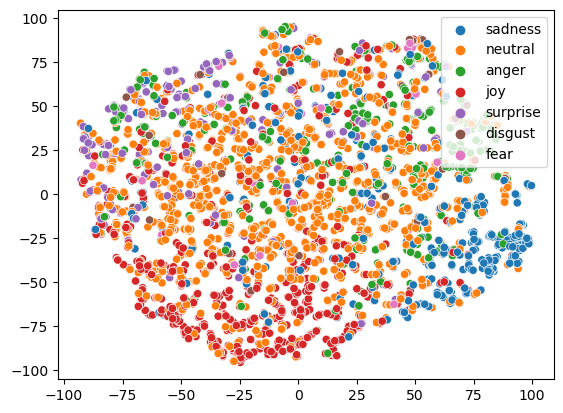

Epoch: 1 - Train Loss: 4.785506044501286


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.18s/it]


Cosine Similarity between mods: 0.7065344577453503
General - KNN F1: 0.5765889782330025 Acc: 0.569981822903142
Iemocap - KNN F1: 0.6824842864719833 Acc: 0.7002417405318292
Iemocap - KNN F1 - Only Audio: 0.3930058139221578
Meld - KNN F1: 0.5164842898160547 Acc: 0.5080459770114942
Meld - KNN F1 - Only Audio: 0.12687292647556667
Iemocap - KNN F1 (macro): 0.45921772072743466
Meld - KNN F1 (macro): 0.37199806842104344


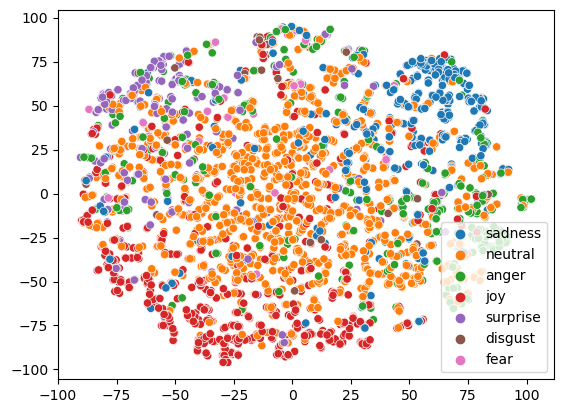

Epoch: 2 - Train Loss: 4.534662564145269


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.19s/it]


Cosine Similarity between mods: 0.6765207564542894
General - KNN F1: 0.6219381332658104 Acc: 0.6159439106725526
Iemocap - KNN F1: 0.754764618162606 Acc: 0.7574536663980661
Iemocap - KNN F1 - Only Audio: 0.4325045715013016
Meld - KNN F1: 0.5455100957657606 Acc: 0.5486590038314176
Meld - KNN F1 - Only Audio: 0.12646281538300078
Iemocap - KNN F1 (macro): 0.4999451162803996
Meld - KNN F1 (macro): 0.38008343889696944


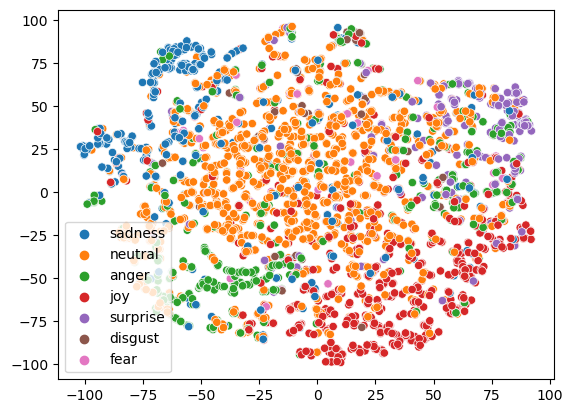

Epoch: 3 - Train Loss: 4.416624767584436


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.18s/it]


Cosine Similarity between mods: 0.6630109075260484
General - KNN F1: 0.6053947451149683 Acc: 0.6019215788106985
Iemocap - KNN F1: 0.6920159139340212 Acc: 0.6913779210314263
Iemocap - KNN F1 - Only Audio: 0.37319804193440104
Meld - KNN F1: 0.5635536444771501 Acc: 0.5593869731800766
Meld - KNN F1 - Only Audio: 0.13317516655937753
Iemocap - KNN F1 (macro): 0.3953354565932254
Meld - KNN F1 (macro): 0.38587370689856443


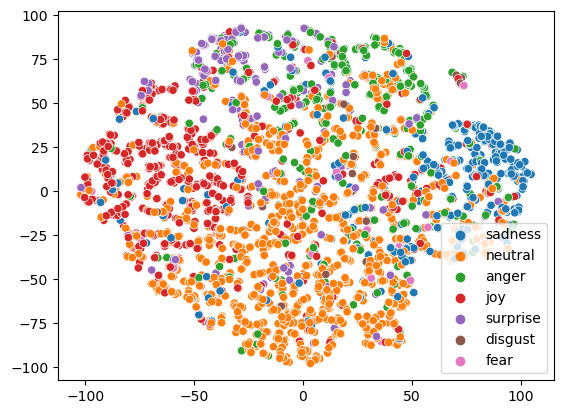

Epoch: 4 - Train Loss: 4.3349826437217995


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.17s/it]


Cosine Similarity between mods: 0.7092635898396926
General - KNN F1: 0.6299843968608473 Acc: 0.6356790444040509
Iemocap - KNN F1: 0.7371464017155023 Acc: 0.7365028203062046
Iemocap - KNN F1 - Only Audio: 0.41008892650959794
Meld - KNN F1: 0.5698465287021959 Acc: 0.5877394636015326
Meld - KNN F1 - Only Audio: 0.1820121087217818
Iemocap - KNN F1 (macro): 0.5841108261342484
Meld - KNN F1 (macro): 0.37794305422367


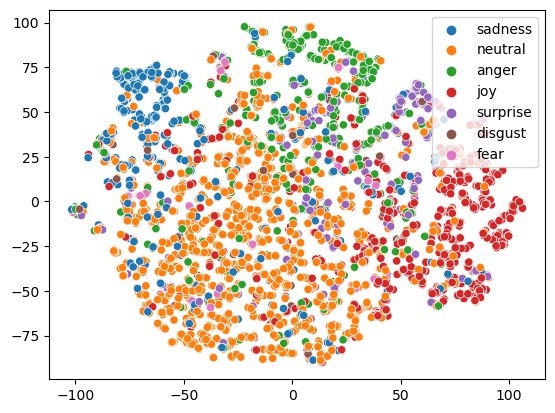

Epoch: 5 - Train Loss: 4.263733332960869


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.17s/it]


Cosine Similarity between mods: 0.6830858157783692
General - KNN F1: 0.63099312274047 Acc: 0.633861334718255
Iemocap - KNN F1: 0.7428246801677951 Acc: 0.7381144238517324
Iemocap - KNN F1 - Only Audio: 0.45025461830273156
Meld - KNN F1: 0.572367186181967 Acc: 0.5842911877394636
Meld - KNN F1 - Only Audio: 0.20802631531646765
Iemocap - KNN F1 (macro): 0.4896682511346357
Meld - KNN F1 (macro): 0.38662637731674565


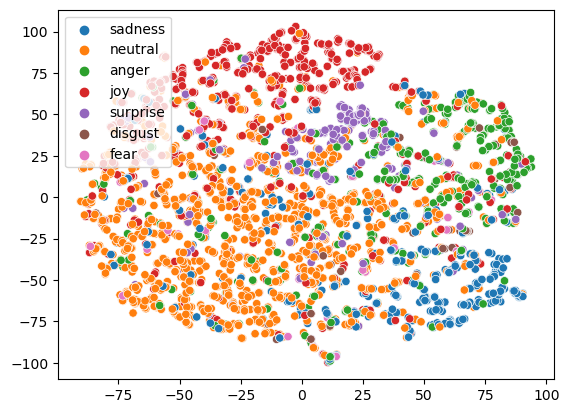

Epoch: 6 - Train Loss: 4.200421862831872


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.21s/it]


Cosine Similarity between mods: 0.6988968057961812
General - KNN F1: 0.6143890591055013 Acc: 0.6154245650480394
Iemocap - KNN F1: 0.7141840583677944 Acc: 0.7147461724415793
Iemocap - KNN F1 - Only Audio: 0.48665255523695106
Meld - KNN F1: 0.5631422163557572 Acc: 0.5681992337164751
Meld - KNN F1 - Only Audio: 0.2448189763740529
Iemocap - KNN F1 (macro): 0.5661192106794967
Meld - KNN F1 (macro): 0.38281587714740806


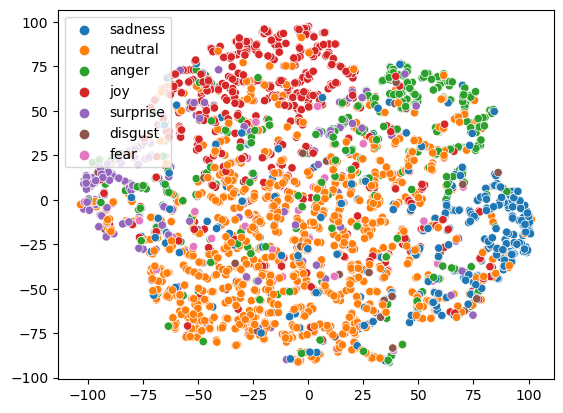

Epoch: 7 - Train Loss: 4.1496483604225824


100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.41s/it]


Cosine Similarity between mods: 0.7110331101220665
General - KNN F1: 0.6203122180994735 Acc: 0.6260711503505583
Iemocap - KNN F1: 0.7345044381968686 Acc: 0.7268331990330379
Iemocap - KNN F1 - Only Audio: 0.46486560681308414
Meld - KNN F1: 0.5620918735231162 Acc: 0.5781609195402299
Meld - KNN F1 - Only Audio: 0.31348903071870465
Iemocap - KNN F1 (macro): 0.42010166473808713
Meld - KNN F1 (macro): 0.37793794136183984


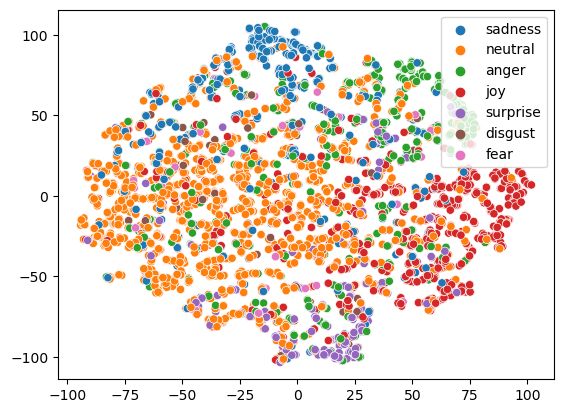

Epoch: 8 - Train Loss: 4.100168195054484


100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.41s/it]


Cosine Similarity between mods: 0.6856688343683053
General - KNN F1: 0.6414984744273483 Acc: 0.6468449753310829
Iemocap - KNN F1: 0.7705833907345226 Acc: 0.7663174858984689
Iemocap - KNN F1 - Only Audio: 0.4579992218190481
Meld - KNN F1: 0.5736436385676887 Acc: 0.5900383141762452
Meld - KNN F1 - Only Audio: 0.22261970072451343
Iemocap - KNN F1 (macro): 0.6173265186849844
Meld - KNN F1 (macro): 0.386728127280668


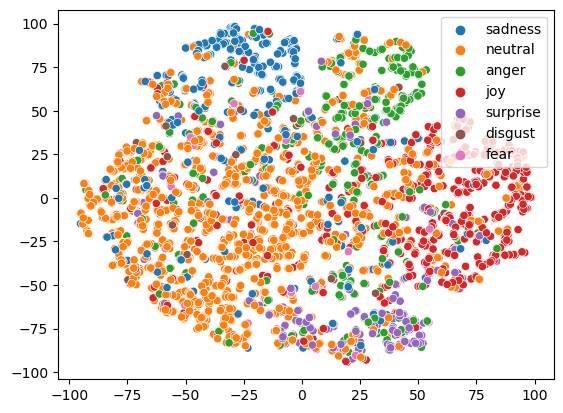

Epoch: 9 - Train Loss: 4.061785962021047


100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.27s/it]


Cosine Similarity between mods: 0.6932710000243443
General - KNN F1: 0.6327574288128666 Acc: 0.6320436250324591
Iemocap - KNN F1: 0.7572533338130342 Acc: 0.7534246575342466
Iemocap - KNN F1 - Only Audio: 0.4616031653213358
Meld - KNN F1: 0.570872646434042 Acc: 0.5743295019157089
Meld - KNN F1 - Only Audio: 0.24217709741750926
Iemocap - KNN F1 (macro): 0.5037722698507011
Meld - KNN F1 (macro): 0.392124246569863


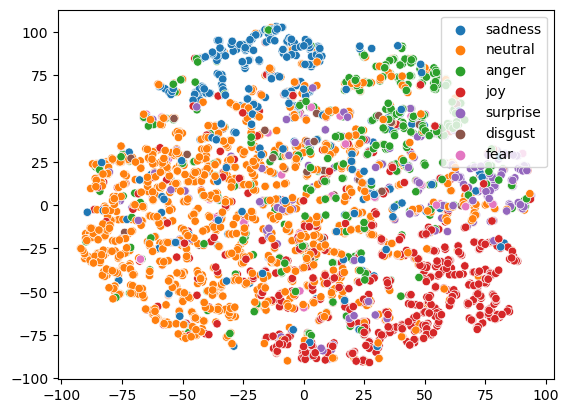

Epoch: 10 - Train Loss: 4.033031279237007


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.18s/it]


Cosine Similarity between mods: 0.6976503794671839
General - KNN F1: 0.6305632674025163 Acc: 0.6411321734614386
Iemocap - KNN F1: 0.7601126953835584 Acc: 0.7566478646253022
Iemocap - KNN F1 - Only Audio: 0.4896387959842859
Meld - KNN F1: 0.5622139263021824 Acc: 0.5862068965517241
Meld - KNN F1 - Only Audio: 0.2413846044350666
Iemocap - KNN F1 (macro): 0.5108932523571745
Meld - KNN F1 (macro): 0.36519673984456336


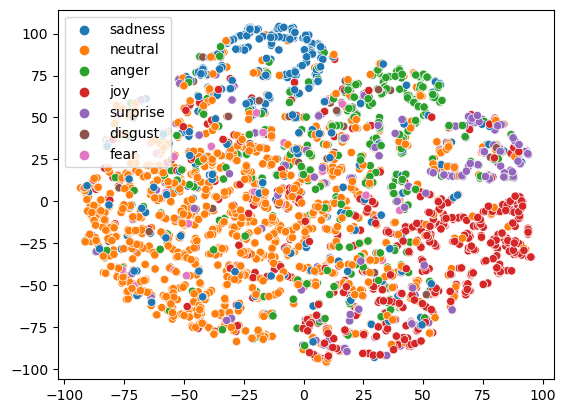

Epoch: 11 - Train Loss: 4.005215561761397


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.18s/it]


Cosine Similarity between mods: 0.7226317154838029
General - KNN F1: 0.6358207667302939 Acc: 0.6429498831472344
Iemocap - KNN F1: 0.7589170078921694 Acc: 0.7534246575342466
Iemocap - KNN F1 - Only Audio: 0.4700319020874411
Meld - KNN F1: 0.571444146694488 Acc: 0.5904214559386973
Meld - KNN F1 - Only Audio: 0.2843970540887776
Iemocap - KNN F1 (macro): 0.6089177770999192
Meld - KNN F1 (macro): 0.38663828175563514


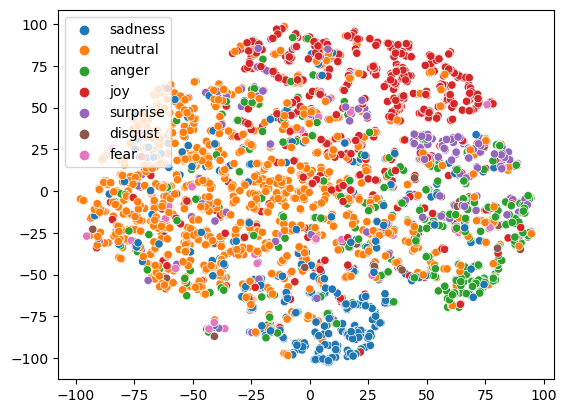

Epoch: 12 - Train Loss: 3.982151090254527


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.20s/it]


Cosine Similarity between mods: 0.7100360784181463
General - KNN F1: 0.6282897283270176 Acc: 0.6395741365878993
Iemocap - KNN F1: 0.7677510907255636 Acc: 0.765511684125705
Iemocap - KNN F1 - Only Audio: 0.45103163572747496
Meld - KNN F1: 0.5561734065345453 Acc: 0.5796934865900383
Meld - KNN F1 - Only Audio: 0.2864690729844715
Iemocap - KNN F1 (macro): 0.6104551136395551
Meld - KNN F1 (macro): 0.3658228355125355


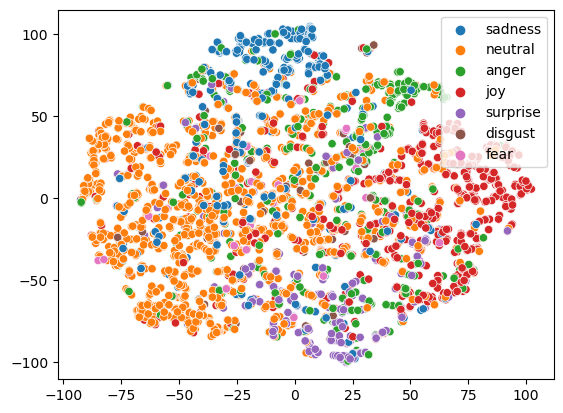

Epoch: 13 - Train Loss: 3.961721902528498


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.17s/it]


Cosine Similarity between mods: 0.7033976295092792
General - KNN F1: 0.6242174929977409 Acc: 0.6273695144118411
Iemocap - KNN F1: 0.7333363794133598 Acc: 0.7276390008058018
Iemocap - KNN F1 - Only Audio: 0.47972879719228584
Meld - KNN F1: 0.5689280930932552 Acc: 0.5796934865900383
Meld - KNN F1 - Only Audio: 0.24291169677539856
Iemocap - KNN F1 (macro): 0.4925701900474205
Meld - KNN F1 (macro): 0.3933916786985696


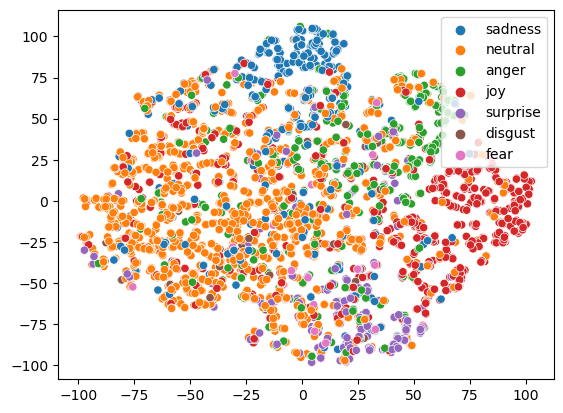

Epoch: 14 - Train Loss: 3.945569926550976


100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.32s/it]


Cosine Similarity between mods: 0.6876876224823909
General - KNN F1: 0.6195434601895011 Acc: 0.6237340950402492
Iemocap - KNN F1: 0.7374903536220591 Acc: 0.7332796132151491
Iemocap - KNN F1 - Only Audio: 0.40808191887763434
Meld - KNN F1: 0.5649814359629942 Acc: 0.571647509578544
Meld - KNN F1 - Only Audio: 0.23680720573937405
Iemocap - KNN F1 (macro): 0.4933468510562565
Meld - KNN F1 (macro): 0.37550806778959206


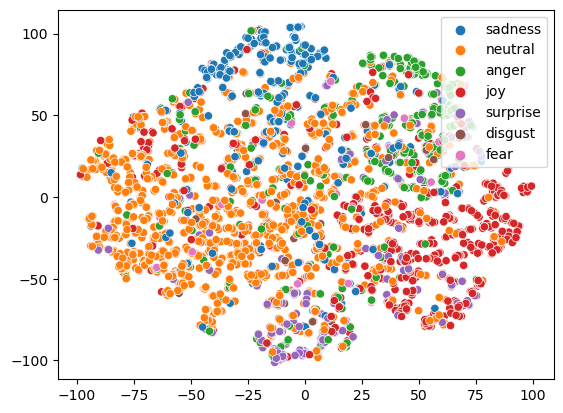

Epoch: 15 - Train Loss: 3.9287530741002676


100%|█████████████████████████████████████████████| 4/4 [00:10<00:00,  2.51s/it]


Cosine Similarity between mods: 0.6978343249419794
General - KNN F1: 0.6129629794140081 Acc: 0.615684237860296
Iemocap - KNN F1: 0.7414524993440185 Acc: 0.7397260273972602
Iemocap - KNN F1 - Only Audio: 0.4488072333544128
Meld - KNN F1: 0.5483565154138691 Acc: 0.5567049808429119
Meld - KNN F1 - Only Audio: 0.25049719391668795
Iemocap - KNN F1 (macro): 0.42245314330892497
Meld - KNN F1 (macro): 0.3764920771880593


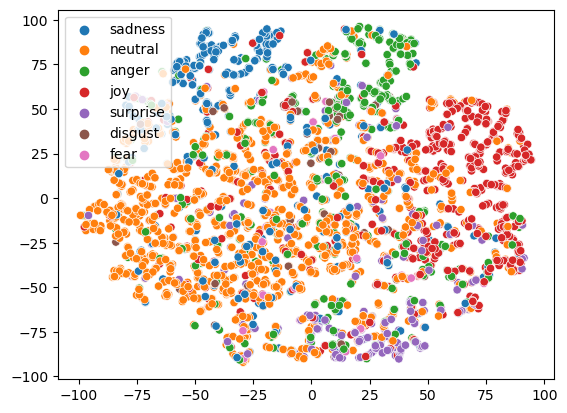

Epoch: 16 - Train Loss: 3.909058333794051


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.20s/it]


Cosine Similarity between mods: 0.6902252015000162
General - KNN F1: 0.613018336115454 Acc: 0.6141262009867566
Iemocap - KNN F1: 0.7464974016700359 Acc: 0.741337630942788
Iemocap - KNN F1 - Only Audio: 0.4220853178581675
Meld - KNN F1: 0.5469543152374771 Acc: 0.553639846743295
Meld - KNN F1 - Only Audio: 0.2359694856838082
Iemocap - KNN F1 (macro): 0.42592105150677523
Meld - KNN F1 (macro): 0.37215214341579367


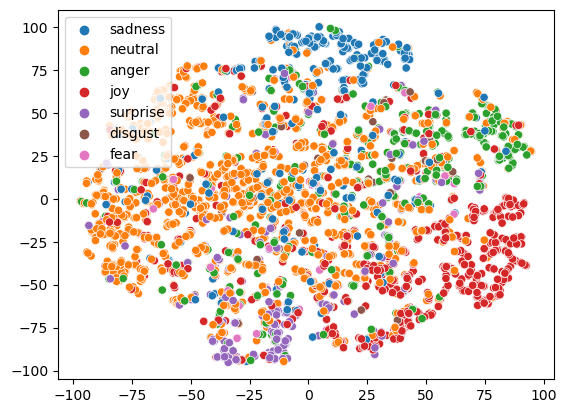

Epoch: 17 - Train Loss: 3.890379630134734


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.16s/it]


Cosine Similarity between mods: 0.7076581005491674
General - KNN F1: 0.6263903736528552 Acc: 0.6411321734614386
Iemocap - KNN F1: 0.7491795613474118 Acc: 0.7437550362610797
Iemocap - KNN F1 - Only Audio: 0.4841616704785493
Meld - KNN F1: 0.5642125786544677 Acc: 0.5923371647509579
Meld - KNN F1 - Only Audio: 0.30092421097160915
Iemocap - KNN F1 (macro): 0.5029735195296082
Meld - KNN F1 (macro): 0.37512996020200984


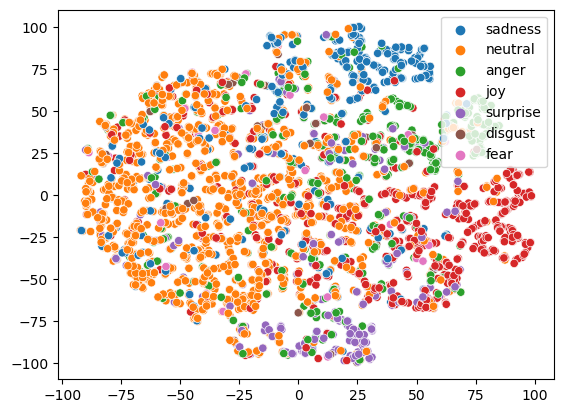

Epoch: 18 - Train Loss: 3.875429874101374


100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.38s/it]


Cosine Similarity between mods: 0.7002091092030682
General - KNN F1: 0.6235661026630028 Acc: 0.6297065697221501
Iemocap - KNN F1: 0.74847266927053 Acc: 0.741337630942788
Iemocap - KNN F1 - Only Audio: 0.45561672925640434
Meld - KNN F1: 0.5575742505945019 Acc: 0.5766283524904214
Meld - KNN F1 - Only Audio: 0.23533632772210883
Iemocap - KNN F1 (macro): 0.4285694614338687
Meld - KNN F1 (macro): 0.37186997585041415


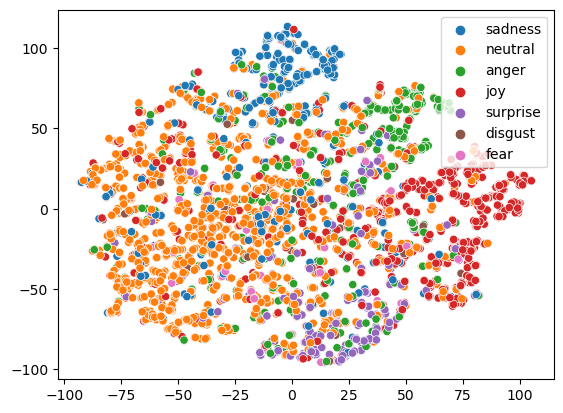

Epoch: 19 - Train Loss: 3.87060660613495


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.12s/it]


Cosine Similarity between mods: 0.6908388496900156
General - KNN F1: 0.6340129343064967 Acc: 0.6359387172163075
Iemocap - KNN F1: 0.7393629909403386 Acc: 0.7332796132151491
Iemocap - KNN F1 - Only Audio: 0.4669009615738864
Meld - KNN F1: 0.5815594644043415 Acc: 0.5896551724137931
Meld - KNN F1 - Only Audio: 0.26523453668444424
Iemocap - KNN F1 (macro): 0.49252596316416586
Meld - KNN F1 (macro): 0.40608834582303827


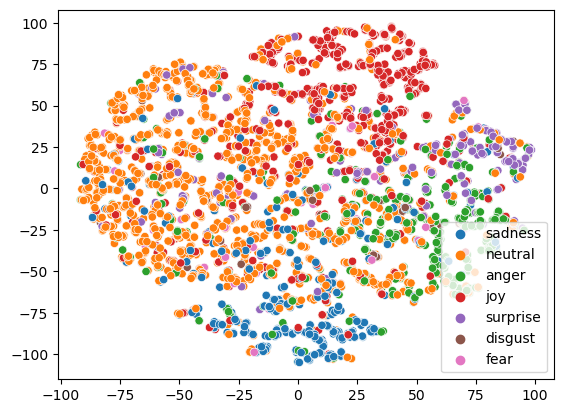

Epoch: 20 - Train Loss: 3.8526591734575484


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.16s/it]


Cosine Similarity between mods: 0.6935585277540534
General - KNN F1: 0.6370357888246352 Acc: 0.6471046481433393
Iemocap - KNN F1: 0.7557834300706713 Acc: 0.7518130539887188
Iemocap - KNN F1 - Only Audio: 0.5001590685605162
Meld - KNN F1: 0.5769068190108988 Acc: 0.5973180076628353
Meld - KNN F1 - Only Audio: 0.2645242759741264
Iemocap - KNN F1 (macro): 0.6047774554765837
Meld - KNN F1 (macro): 0.39186649731890394


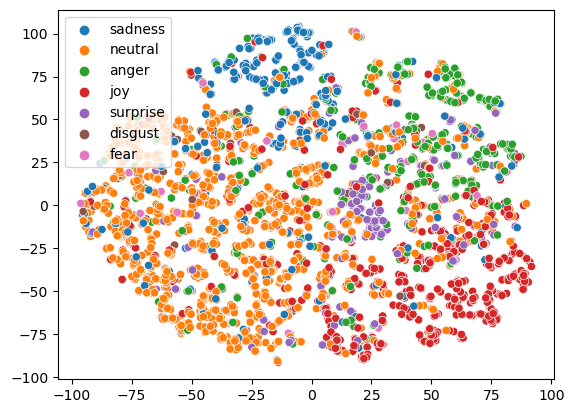

Epoch: 21 - Train Loss: 3.844705844398261


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.21s/it]


Cosine Similarity between mods: 0.6960359987919128
General - KNN F1: 0.6303664436192348 Acc: 0.6341210075305116
Iemocap - KNN F1: 0.7547272942384897 Acc: 0.7526188557614827
Iemocap - KNN F1 - Only Audio: 0.47735768790545524
Meld - KNN F1: 0.5703626840996493 Acc: 0.5777777777777777
Meld - KNN F1 - Only Audio: 0.24166330145639003
Iemocap - KNN F1 (macro): 0.5054141909640987
Meld - KNN F1 (macro): 0.3789898131136149


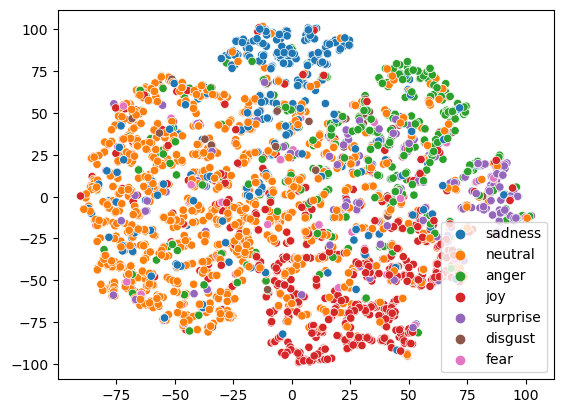

Epoch: 22 - Train Loss: 3.8353594112666403


100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.28s/it]


Cosine Similarity between mods: 0.7196261897021472
General - KNN F1: 0.6191230103802806 Acc: 0.6252921319137886
Iemocap - KNN F1: 0.7331367196301806 Acc: 0.726027397260274
Iemocap - KNN F1 - Only Audio: 0.4777370636176914
Meld - KNN F1: 0.5662328797517112 Acc: 0.5773946360153257
Meld - KNN F1 - Only Audio: 0.33271927276651675
Iemocap - KNN F1 (macro): 0.4904754677414709
Meld - KNN F1 (macro): 0.3848299142104289


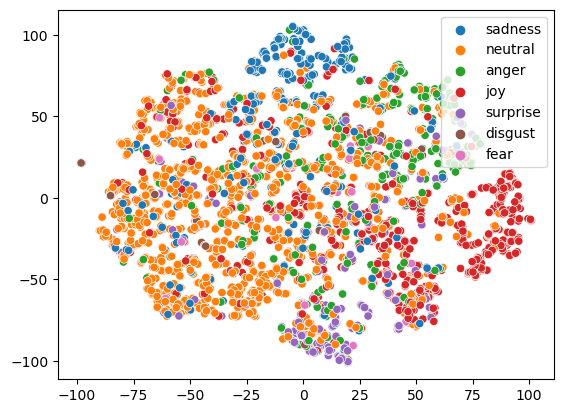

Epoch: 23 - Train Loss: 3.822379595834878


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.23s/it]


Cosine Similarity between mods: 0.6970104216538724
General - KNN F1: 0.6276879630092973 Acc: 0.6284082056608673
Iemocap - KNN F1: 0.7453048116083628 Acc: 0.7405318291700241
Iemocap - KNN F1 - Only Audio: 0.43615938808359345
Meld - KNN F1: 0.5700625178553956 Acc: 0.575095785440613
Meld - KNN F1 - Only Audio: 0.3091553969573035
Iemocap - KNN F1 (macro): 0.600920557696011
Meld - KNN F1 (macro): 0.38423761016409685


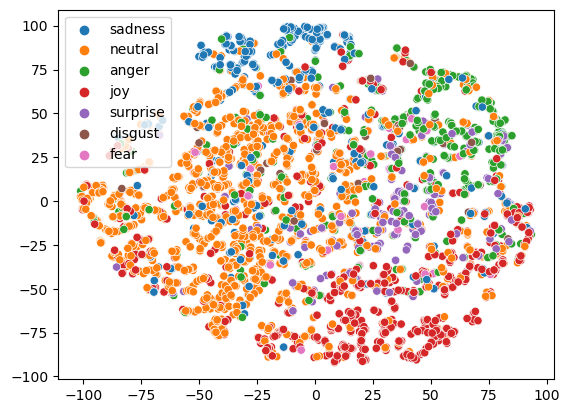

Epoch: 24 - Train Loss: 3.8150463347394474


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.16s/it]


Cosine Similarity between mods: 0.6966518262428792
General - KNN F1: 0.63347325400204 Acc: 0.6387951181511295
Iemocap - KNN F1: 0.7585776037290632 Acc: 0.7534246575342466
Iemocap - KNN F1 - Only Audio: 0.4335226714764898
Meld - KNN F1: 0.5727961643228249 Acc: 0.5842911877394636
Meld - KNN F1 - Only Audio: 0.28863556800350376
Iemocap - KNN F1 (macro): 0.6097334553169957
Meld - KNN F1 (macro): 0.3898810376017204


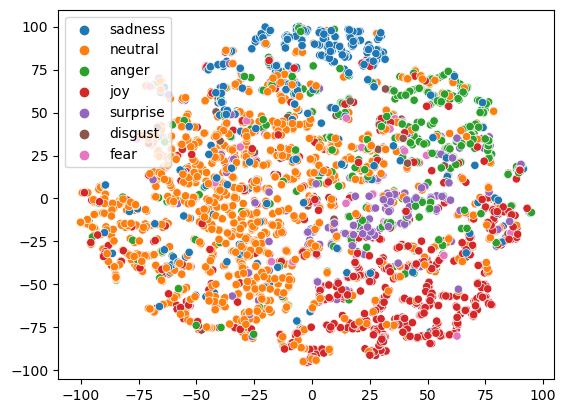

Epoch: 25 - Train Loss: 3.8027526481293417


100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.33s/it]


Cosine Similarity between mods: 0.6942312854260663
General - KNN F1: 0.6269766822495554 Acc: 0.6364580628408205
Iemocap - KNN F1: 0.7585664213937996 Acc: 0.7566478646253022
Iemocap - KNN F1 - Only Audio: 0.4996595810992533
Meld - KNN F1: 0.5610831907266655 Acc: 0.5793103448275863
Meld - KNN F1 - Only Audio: 0.28531666479741735
Iemocap - KNN F1 (macro): 0.6069176923352767
Meld - KNN F1 (macro): 0.370702944712718


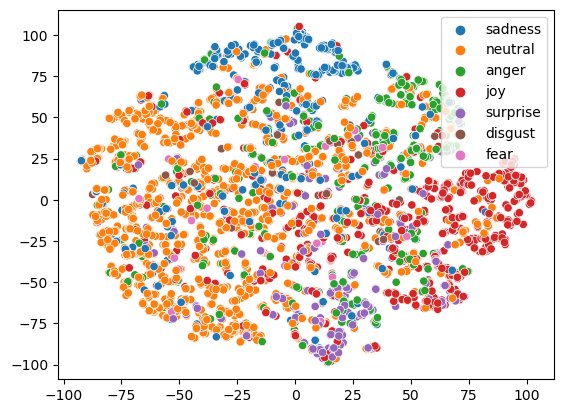

Epoch: 26 - Train Loss: 3.7894584153259103


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.18s/it]


Cosine Similarity between mods: 0.6755297712089798
General - KNN F1: 0.6286630471573602 Acc: 0.6354193715917943
Iemocap - KNN F1: 0.7262534666098847 Acc: 0.7195809830781628
Iemocap - KNN F1 - Only Audio: 0.4366689726586539
Meld - KNN F1: 0.5779926907947734 Acc: 0.5954022988505747
Meld - KNN F1 - Only Audio: 0.25696503343849547
Iemocap - KNN F1 (macro): 0.420810567641842
Meld - KNN F1 (macro): 0.39199362330763504


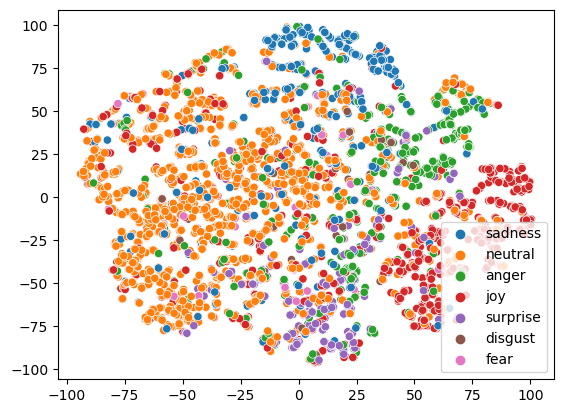

Epoch: 27 - Train Loss: 3.7778336650589033


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.12s/it]


Cosine Similarity between mods: 0.6793719747103025
General - KNN F1: 0.6245616449286677 Acc: 0.6359387172163075
Iemocap - KNN F1: 0.7434147705920123 Acc: 0.7348912167606769
Iemocap - KNN F1 - Only Audio: 0.44037243130870257
Meld - KNN F1: 0.5626725322399009 Acc: 0.5888888888888889
Meld - KNN F1 - Only Audio: 0.24515623472487144
Iemocap - KNN F1 (macro): 0.4961634080539004
Meld - KNN F1 (macro): 0.3730324079086803


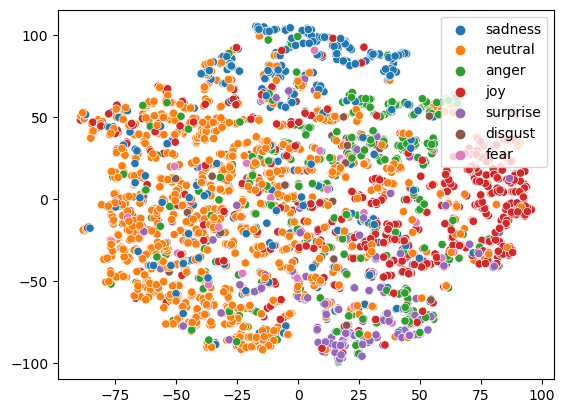

Epoch: 28 - Train Loss: 3.7746240268685662


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.15s/it]


Cosine Similarity between mods: 0.6919258571358292
General - KNN F1: 0.6286073846867907 Acc: 0.6364580628408205
Iemocap - KNN F1: 0.7353711626775195 Acc: 0.7276390008058018
Iemocap - KNN F1 - Only Audio: 0.4112409016978558
Meld - KNN F1: 0.5759936676914279 Acc: 0.593103448275862
Meld - KNN F1 - Only Audio: 0.25649458967205846
Iemocap - KNN F1 (macro): 0.494084978917323
Meld - KNN F1 (macro): 0.3780094188262742


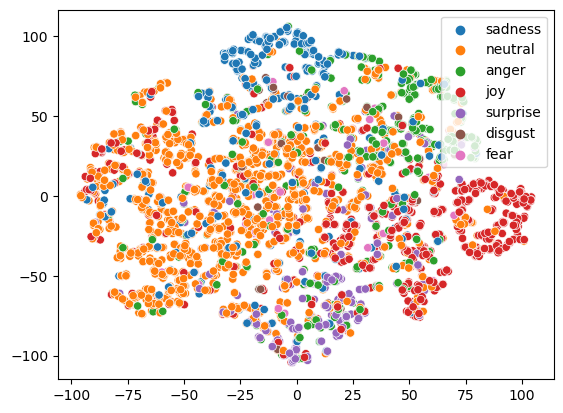

Epoch: 29 - Train Loss: 3.7714195872839045


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.18s/it]


Cosine Similarity between mods: 0.6867993081646813
General - KNN F1: 0.6303893801109349 Acc: 0.6302259153466632
Iemocap - KNN F1: 0.7512573514294709 Acc: 0.7453666398066076
Iemocap - KNN F1 - Only Audio: 0.4951986794366279
Meld - KNN F1: 0.5703886227588497 Acc: 0.5754789272030651
Meld - KNN F1 - Only Audio: 0.2557064424442779
Iemocap - KNN F1 (macro): 0.5030719462716052
Meld - KNN F1 (macro): 0.39068573883084046


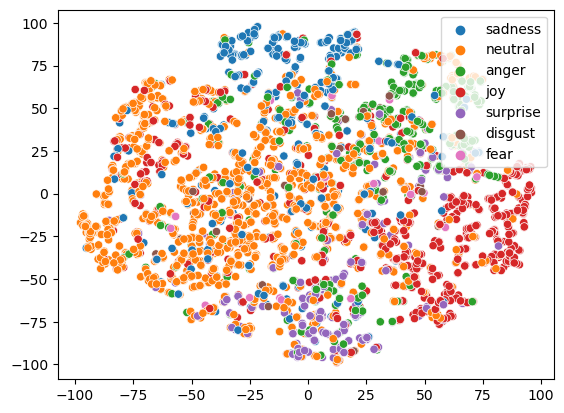

Epoch: 30 - Train Loss: 3.757085542165524


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.14s/it]


Cosine Similarity between mods: 0.6925807369433264
General - KNN F1: 0.6220914982460033 Acc: 0.6346403531550247
Iemocap - KNN F1: 0.7462831514503215 Acc: 0.7381144238517324
Iemocap - KNN F1 - Only Audio: 0.45136483059148247
Meld - KNN F1: 0.5553078874679612 Acc: 0.5854406130268199
Meld - KNN F1 - Only Audio: 0.3201470318737993
Iemocap - KNN F1 (macro): 0.5954666908441523
Meld - KNN F1 (macro): 0.36341605169671887


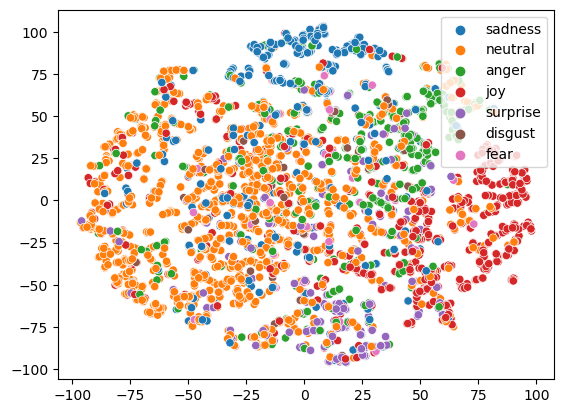

Epoch: 31 - Train Loss: 3.7581339773983187


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.21s/it]


Cosine Similarity between mods: 0.6806466601106044
General - KNN F1: 0.6209963248025965 Acc: 0.6234744222279928
Iemocap - KNN F1: 0.7356642911136301 Acc: 0.7292506043513296
Iemocap - KNN F1 - Only Audio: 0.4538171658309972
Meld - KNN F1: 0.5607347014428571 Acc: 0.5731800766283525
Meld - KNN F1 - Only Audio: 0.29791136732229806
Iemocap - KNN F1 (macro): 0.5875839924553284
Meld - KNN F1 (macro): 0.3806476879936551


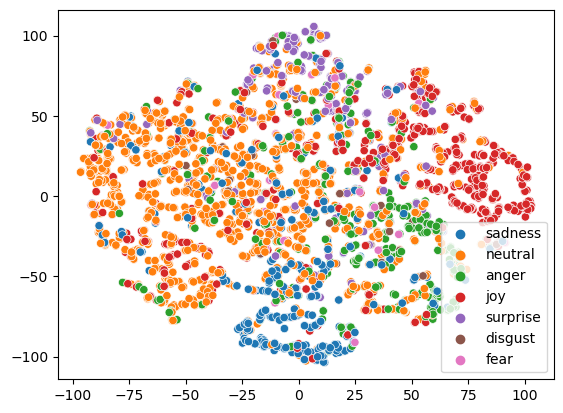

Epoch: 32 - Train Loss: 3.7474039985505447


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.22s/it]


Cosine Similarity between mods: 0.679769543231973
General - KNN F1: 0.6281362573427223 Acc: 0.633861334718255
Iemocap - KNN F1: 0.7392158444137933 Acc: 0.7324738114423852
Iemocap - KNN F1 - Only Audio: 0.4772440157815365
Meld - KNN F1: 0.5716999185915278 Acc: 0.5869731800766284
Meld - KNN F1 - Only Audio: 0.2725911347946498
Iemocap - KNN F1 (macro): 0.4956476296318972
Meld - KNN F1 (macro): 0.39840057388962125


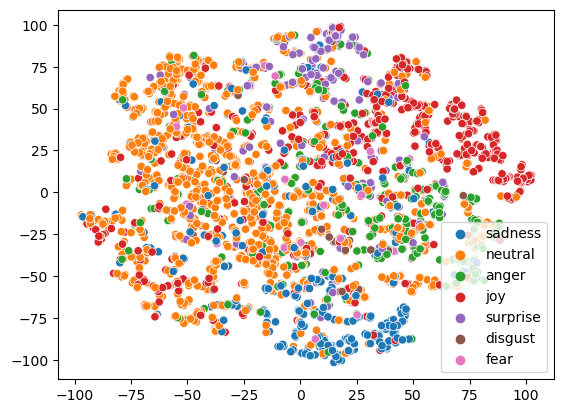

Epoch: 33 - Train Loss: 3.735195143026941


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.16s/it]


Cosine Similarity between mods: 0.6879600855753781
General - KNN F1: 0.6317326674561778 Acc: 0.6390547909633861
Iemocap - KNN F1: 0.7542109754364484 Acc: 0.7493956486704271
Iemocap - KNN F1 - Only Audio: 0.45727209560638976
Meld - KNN F1: 0.5710619213673224 Acc: 0.5865900383141762
Meld - KNN F1 - Only Audio: 0.301396725798979
Iemocap - KNN F1 (macro): 0.5021210012687042
Meld - KNN F1 (macro): 0.3826209627014861


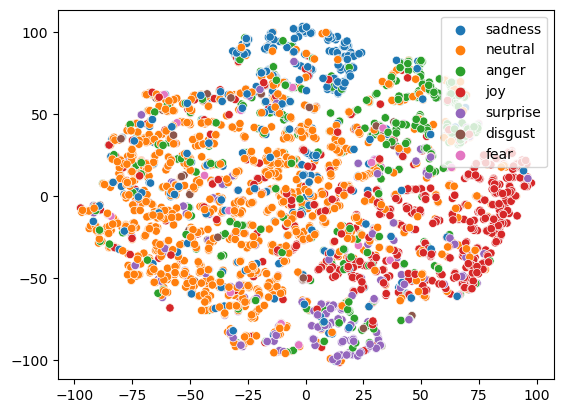

Epoch: 34 - Train Loss: 3.718651689145788


 27%|███████████▌                              | 97/353 [01:44<04:35,  1.08s/it]


KeyboardInterrupt: 

In [49]:
train_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(df_train)))))
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=256, shuffle=True)

test_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(test_df_erc)))))
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False)

PATH_TO_SAVE = 'ESTAMOS_PERTO_AMIGO_ESTOU_AQUI_4_freezed_11'
!mkdir -p {PATH_TO_SAVE}
supcon_model = AudioTextContrastive(
    text_encoder,
    audio_encoder,
    in_features_text=768,
    in_features_audio=dim_embed, 
    hidden_size=768,
    wide_proj=1024,
    proj_size=128, 
    rate=0.1,
)

# Grid search best temperatures
# Try to only fine tune on evaluation datasets
#supcon_model.load_state_dict(torch.load(f'ESTAMOS_PERTO_AMIGO_ESTOU_AQUI_4_freezed_4_layer/pytorch_model_AudioTextCLIP_epoch_9.bin')['model'])

supcon_model.to(0)

scaler = torch.cuda.amp.GradScaler()

step = 0
e = 0
patience = 9999
early_stop_flag = 0
old_f1 = -float('inf')

param_optimizer = list(supcon_model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{
    'params':
    [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
    'weight_decay_rate':
    0.1
}, {
    'params':
    [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
    'weight_decay_rate':
    0.0
}]

scheduler_epochs = 5
opt = torch.optim.AdamW(optimizer_grouped_parameters, lr=0, betas=(0.9, 0.98), eps=1e-8)
#scheduler = torch.optim.lr_scheduler.LinearLR(opt, start_factor=0.5, end_factor=0.9, total_iters=10, last_epoch=- 1, verbose=False)
scheduler = Scheduler(opt, 768, 600)

epochs = 9999

while e < epochs:
    supcon_model.train()
    epoch_loss = 0.0
    proj_val = []
    targets_val = []

    proj_train = []
    targets_train = []

    for i, batch_indices in enumerate(tqdm(train_loader, total=len(train_loader))):
        if i == len(train_loader)-1:
            continue
        batch = df_train.iloc[batch_indices[0]]
        only_text = batch[batch["path"].isna()]
        sentences = only_text["text"].tolist()
        y_text = torch.Tensor(lab_encoder.transform(only_text["label"]))
        y_text_senti = torch.Tensor(lab_encoder_senti.transform(only_text["sentiment_label"]))
        
        only_audio = batch[batch["text"].isna()]
        audio_paths = only_audio["path"].tolist()
        try:
            mfccs, att = audio_tokenizer.batch_tokenize(audio_paths)

            audio_input = {
                "features": mfccs.to(0),
                "attn_masks": att.to(0),
            }
        except:
            audio_input = None

        y_audio = torch.Tensor(lab_encoder.transform(only_audio["label"]))
        y_audio_senti = torch.Tensor(lab_encoder_senti.transform(only_audio["sentiment_label"]))
        
        mult = batch[batch["text"].notna()]
        mult = mult[mult["path"].notna()].reset_index(drop=True)
        
        mult_not_na_idx = mult[mult["label"].notna()].index
        #batch_not_na_idx = batch[batch["label"].notna()].index
        #mult_na_idx = mult[mult["label"].isna()].index
        
        y_mult = torch.Tensor(lab_encoder.transform(mult.iloc[mult_not_na_idx]["label"]))
        
        y_mult_senti = torch.Tensor(lab_encoder_senti.transform(mult["sentiment_label"]))
        
        audio_path_mult = [str(t['path']) for _, t in mult.iterrows()]
        
        mfccs_mult, att_mult = audio_tokenizer.batch_tokenize(audio_path_mult)
        
        sentences_mult = [str(t['text']) for _, t in mult.iterrows()]
        
        multimodal = {'sentences': sentences_mult, 
                      'audio_input': {"features": mfccs_mult.to(0), "attn_masks": att_mult.to(0)}}
        
        target = torch.cat([y_text, y_audio, y_mult]).long().cuda()
        target_senti = torch.cat([y_text_senti, y_audio_senti, y_mult_senti]).long().cuda()
        
        x = [sentences, audio_input, multimodal]
        
        if len(sentences) == 0:
            x[0] = None
        if len(audio_paths) == 0:
            x[1] = None
        if len(sentences_mult) == 0:
            x[2] = None

        with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
            
            out = supcon_model(x)
            
            # Multimodal loss
            if x[-1] is not None:
                x_mult_text = out["x_mult_text"]
                x_mult_audio = out["x_mult_audio"]
                x_mult_text_norm = F.normalize(x_mult_text, dim=-1)
                x_mult_audio_norm = F.normalize(x_mult_audio, dim=-1)
                
                #weights = torch.stack([torch.norm(x_mult_audio, dim=-1), torch.norm(x_mult_text, dim=-1)], dim=0).detach()
                weights = torch.cat([torch.norm(x_mult_audio, dim=-1), torch.norm(x_mult_text, dim=-1)], dim=0).detach()
                #weights = torch.ones_like(weights)
                
                # Augument modality
                augs = random.choices(
                    population=[0, 1, 2],
                    weights=[0.5, 0.25, 0.25],
                    k=len(x_mult_text)
                )
                
                x_mult = torch.stack([F.normalize(x_mult_text + x_mult_audio, dim=-1), 
                                      x_mult_text_norm, 
                                     x_mult_audio_norm], dim=1)
                
                x_mult = x_mult[list(range(len(augs))), augs, :] 
                
                x_mult_wide = F.normalize(out["x_mult_text_wide"] + out["x_mult_audio_wide"], dim=-1)
                
                # Add weighted contrastive loss
                #x_mult_text = x_mult_text_norm.unsqueeze(dim=1)
                #x_mult_audio = x_mult_audio_norm.unsqueeze(dim=1)
                #mult = torch.cat([x_mult_text, x_mult_audio], dim=1)
                
                out_x, out_x_wide = None, None
                
                if x[0] is not None:
                    if x[1] is not None:
                        out_x = torch.cat([out["x_text"], out["x_audio"], x_mult], dim=0) #.unsqueeze(dim=1)
                        out_x_lab = torch.cat([out["x_text"], out["x_audio"], x_mult[mult_not_na_idx]], dim=0) #.unsqueeze(dim=1)
                        out_x_wide = torch.cat([out["x_text_wide"], out["x_audio_wide"], x_mult_wide[mult_not_na_idx]], dim=0)
                    else:
                        out_x = torch.cat([out["x_text"], x_mult], dim=0) #.unsqueeze(dim=1)
                        out_x_lab = torch.cat([out["x_text"], x_mult[mult_not_na_idx]], dim=0) #.unsqueeze(dim=1)
                        out_x_wide = torch.cat([out["x_text_wide"], x_mult_wide[mult_not_na_idx]], dim=0)
                elif x[1] is not None:
                    out_x = torch.cat([out["x_audio"], x_mult], dim=0) #.unsqueeze(dim=1)
                    out_x_lab = torch.cat([out["x_audio"], x_mult[mult_not_na_idx]], dim=0) #.unsqueeze(dim=1)
                    out_x_wide = torch.cat([out["x_audio_wide"], x_mult_wide[mult_not_na_idx]], dim=0)
                else:
                    out_x = x_mult.unsqueeze(dim=1)
                    out_x_lab = x_mult[mult_not_na_idx] #.unsqueeze(dim=1)
                    out_x_wide = x_mult_wide[mult_not_na_idx]
                
                # fera ta
                
                loss = 0.8 * (0.9 * sup_contrastive_loss(out_x_lab, target, temperature=0.1) + 0.1 * sup_contrastive_loss(out_x, target_senti, temperature=0.1)) \
                        + 0.2 * unsupervised_contrastive_loss(x_mult_text_norm, x_mult_audio_norm, temperature=0.1, weights=weights)
                #loss = 0.5 * (0.5 * supcon_loss(out_x_lab, labels=target) + 0.5 * supcon_loss_senti(out_x, labels=target_senti)) + 0.5 * supcon_loss_intra(mult, weights=weights) 
            else:
                if x[0] is not None:
                    if x[1] is not None:
                        out_x = torch.cat([out["x_text"], out["x_audio"]], dim=0).unsqueeze(dim=1)
                        out_x_wide = torch.cat([out["x_text_wide"], out["x_audio_wide"]], dim=0)
                    else:
                        out_x = out["x_text"]
                        out_x_wide = out["x_text_wide"]
                else:
                    if x[1] is not None:
                        out_x = out["x_audio"]
                        out_x_wide = out["x_audio_wide"]
                    else:
                        raise Exception("Nothing to work :()")
                        
                loss = 0.8 * sup_contrastive_loss(out_x_lab, target, temperature=0.1) + 0.2 * sup_contrastive_loss(out_x, target_senti, temperature=0.1) #+ 0.8 * unsupervised_contrastive_loss(x_mult_text_norm, x_mult_audio_norm, temperature=0.8, weights=None)

        scaler.scale(loss).backward()
        scaler.unscale_(opt)

        #torch.nn.utils.clip_grad_norm_(supcon_model.parameters(), 30.0)
        scaler.step(opt)
        scheduler.step()
        scaler.update()
        
        opt.zero_grad(set_to_none=True)

        epoch_loss += loss.item()
        proj_train.append(np.array(out_x_wide.detach().cpu()))
        targets_train.append(np.array(target.cpu()))

        del out_x
        del x_mult
        del out_x_wide
        gc.collect()
        torch.cuda.empty_cache()
    #scheduler.step()
    proj_train = np.concatenate(proj_train, axis=0)
    targets_train = np.concatenate(targets_train, axis=0)
    
    clf = FaissKNeighbors(k=128)
    clf.fit(proj_train, np.array(targets_train, dtype=int))

    epoch_loss = epoch_loss/len(train_loader)
    #supcon_model.eval()
    preds = []
    targets = []
    css = 0.0
    wide_audio = []
    
    for i, batch_indices in enumerate(tqdm(test_loader, total=len(test_loader))):
        with torch.no_grad():
        
            multimodal_batch = test_df_erc.iloc[batch_indices[0]]

            audio_path_mult = [str(t['path']) for _, t in multimodal_batch.iterrows()]
            mfccs_mult, att_mult = audio_tokenizer.batch_tokenize(audio_path_mult)

            sentences_mult = [str(t['text']) for _, t in multimodal_batch.iterrows()]

            multimodal = {'sentences': sentences_mult, 
                          'audio_input': {"features": mfccs_mult.to(0), "attn_masks": att_mult.to(0)}}
        
            target = torch.Tensor(lab_encoder.transform(list(multimodal_batch["label"])))

            x = [None, None, multimodal]
            with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
                out = supcon_model(x)
            
            # Multimodal loss
            out_x_wide = F.normalize(out["x_mult_text_wide"] + out["x_mult_audio_wide"], dim=-1)
            
            cs = F.cosine_similarity(F.normalize(out["x_mult_text_wide"], dim=-1), F.normalize(out["x_mult_audio_wide"], dim=-1))

            wide = np.array(out_x_wide.cpu())
            wide_audio.append(np.array(F.normalize(out["x_mult_audio_wide"], dim=-1).cpu()))
            pred = clf.predict(wide)
            preds.append(pred)

            assert len(wide) == len(pred)

            proj_val.append(wide)
            targets_val.append(np.array(target.cpu()))
            css += np.sum(np.array(cs.cpu()))
            del out_x_wide
            gc.collect()
            torch.cuda.empty_cache()

    proj_val = np.concatenate(proj_val, axis=0)
    wide_audio = np.concatenate(wide_audio, axis=0)
    targets_val = np.concatenate(targets_val, axis=0)
    
    preds = np.array(np.concatenate(preds, axis=0))
    
    css = css / len(test_df_erc)

    general_f1 = f1_score(targets_val, preds, average='weighted')
    general_acc = accuracy_score(targets_val, preds)
    
    print(f'Cosine Similarity between mods: {css}')
    
    meld_idx = test_df_erc[test_df_erc["source"] == "meld"].index
    iemocap_idx = test_df_erc[test_df_erc["source"] != "meld"].index
    
    general_f1_iemocap = f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='weighted')
    general_f1_iemocap_audio = f1_score(targets_val[iemocap_idx], clf.predict(wide_audio)[iemocap_idx], average='weighted')
    general_acc_iemocap = accuracy_score(targets_val[iemocap_idx], preds[iemocap_idx])
    
    general_f1_meld = f1_score(targets_val[meld_idx], preds[meld_idx], average='weighted')
    general_f1_meld_audio = f1_score(targets_val[meld_idx], clf.predict(wide_audio)[meld_idx], average='weighted')
    general_acc_meld = accuracy_score(targets_val[meld_idx], preds[meld_idx])
    
    print(f'General - KNN F1: {general_f1} Acc: {general_acc}')
    print(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
    print(f'Iemocap - KNN F1 - Only Audio: {general_f1_iemocap_audio}')
    print(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')
    print(f'Meld - KNN F1 - Only Audio: {general_f1_meld_audio}')
    print(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
    print(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")

    try:
        tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=5).fit_transform(proj_val)

        sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=lab_encoder.inverse_transform(list(np.array(targets_val, dtype=int))) , palette='tab10')
        plt.show()
    
    except:
        pass
    
    print(f'Epoch: {e + 1} - Train Loss: {epoch_loss}')
    e += 1
    
    #if e == scheduler_epochs: # Unfreeze text encoder
    #    for i, (name, param) in enumerate(list(supcon_model.text_encoder.named_parameters())):
    #        param.requires_grad = True

    with open(f"{PATH_TO_SAVE}/metrics_epoch_{e}.txt", "w") as f:
        f.write(f'General - KNN F1: {general_f1} Acc: {general_acc}')
        f.write(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
        f.write(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')
        f.write(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
        
        f.write(f'Iemocap - KNN F1 - Only Audio: {general_f1_iemocap_audio}')
        f.write(f'Meld - KNN F1 - Only Audio: {general_f1_meld_audio}')
        f.write(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
        
        f.write(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")
        
    checkpoint = {"model": supcon_model.state_dict(),
              "optimizer": opt.state_dict(),
              "scaler": scaler.state_dict()}
    torch.save(checkpoint, f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_{e}.bin')

In [ ]:
"""
Cosine Similarity between mods: 0.6148036817116292
General - KNN F1: 0.652949920693673 Acc: 0.6535964684497533
Iemocap - KNN F1: 0.7621117618450867 Acc: 0.7558420628525383
Iemocap - KNN F1 - Only Audio: 0.48286032752145575
Meld - KNN F1: 0.6025222678926638 Acc: 0.6049808429118774
Iemocap - KNN F1 (macro): 0.6085758686292261
Meld - KNN F1 (macro): 0.41899567212117655

Epoch: 31 - Train Loss: 6.175596459077136
"""

## Eval

In [ ]:
#import pickle
#pickle.dump(kmeans, open("./transformer_1_layer_repetindo/kmeans_200_clusters_curr.pkl", 'wb'))

In [50]:
gc.collect()

1361

In [ ]:
#PATH_TO_SAVE = 'ESTAMOS_PERTO_AMIGO_ESTOU_AQUI_4_freezed_5_layer_pivoting_to_speech_training'

In [ ]:
#torch.load(f'pre_test_final_2/pytorch_model_AudioTextCLIP_epoch_35.bin')['model']
#torch.load(f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_1.bin')['model']

In [52]:
PATH_TO_SAVE = 'ESTAMOS_PERTO_AMIGO_ESTOU_AQUI_4_freezed_11'

supcon_model = AudioTextContrastive(
    text_encoder,
    audio_encoder,
    in_features_text=768,
    in_features_audio=dim_embed, 
    hidden_size=768,
    wide_proj=1024,
    proj_size=128, 
    rate=0.2,
).cuda()
supcon_model.load_state_dict(torch.load(f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_23.bin')['model'])

<All keys matched successfully>

In [53]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [54]:
get_n_params(supcon_model)

165818255

In [55]:
supcon_model.eval()

AudioTextContrastive(
  (audio_encoder): AudioEncoderMFCCHU(
    (vq): ResidualVQ(
      (layers): ModuleList(
        (0-3): 4 x VectorQuantize(
          (project_in): Linear(in_features=45, out_features=128, bias=True)
          (project_out): Linear(in_features=128, out_features=45, bias=True)
          (_codebook): EuclideanCodebook()
        )
      )
    )
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (project): Sequential(
      (0): Linear(in_features=45, out_features=768, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=768, out_features=768, bias=True)
    )
    (transf_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (linear1): Linear(in_features=768, out_features=3072, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=30

In [56]:
import pickle

In [61]:
supcon_model.train()
test = supcon_model([["I Hate you, i believe you are shit!", "You are my best friend, love you!"],None, None])
torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_text_wide"][1, :], dim=-1))

tensor(0.3975, device='cuda:0', grad_fn=<DotBackward0>)

In [62]:
test = supcon_model([["The best man ever, keep the good work!", "you are my best friend, love you!"],None, None])
torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_text_wide"][1, :], dim=-1))

tensor(0.9975, device='cuda:0', grad_fn=<DotBackward0>)

In [63]:
test = supcon_model([["I Hate you, i believe you are shit!", "Fuck you, you should not be alive"],None, None])
torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_text_wide"][1, :], dim=-1))

tensor(0.9951, device='cuda:0', grad_fn=<DotBackward0>)

In [64]:
test = supcon_model([["I love you, mate!", "Fuck you, you should not be alive"],None, None])
torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_text_wide"][1, :], dim=-1))

tensor(0.4428, device='cuda:0', grad_fn=<DotBackward0>)

In [81]:
supcon_model.train()
with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.sad.100.wav"])
    audio_input = {
        "features": m.to(0),
        "attn_masks": a.to(0),
    }
    test = supcon_model([["I am very sad"],audio_input, None])
    print(torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_audio_wide"][0, :], dim=-1)))

tensor(0.9530, device='cuda:0')


In [ ]:
torch.norm(test["x_text"][0, :])

In [ ]:
torch.norm(test["x_audio"][0, :])

In [82]:
supcon_model.train()
supcon_model.training = False
with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.sad.101.wav"])
    audio_input = {
        "features": m.to(0),
        "attn_masks": a.to(0),
    }
    test = supcon_model([["I love my girlfriend, but she died"],audio_input, None])
    print(torch.dot(test["x_text"][0, :], test["x_audio"][0, :]))

tensor(0.9941, device='cuda:0')


In [ ]:
___

In [85]:
supcon_model.train()
supcon_model.training = False
dropout_modules = [module for module in supcon_model.modules() if isinstance(module,torch.nn.Dropout)]
[module.eval() for module in dropout_modules]

with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.sad.279.wav"])
    audio_input = {
        "features": m.to(0),
        "attn_masks": a.to(0),
    }
    test = supcon_model([["I am happy"], audio_input, None])
    print(torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_audio_wide"][0, :], dim=-1)))

tensor(0.2686, device='cuda:0')


In [92]:
supcon_model.train()
supcon_model.training = False
dropout_modules = [module for module in supcon_model.modules() if isinstance(module,torch.nn.Dropout)]
[module.eval() for module in dropout_modules]

with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.sad.279.wav"])
    audio_input = {
        "features": m.to(0),
        "attn_masks": a.to(0),
    }
    test = supcon_model([["My dog was great, but he was also cute! Today he is dead"], audio_input, None])
    print(torch.dot(F.normalize(test["x_text"][0, :], dim=-1), F.normalize(test["x_audio"][0, :], dim=-1)))

tensor(0.9478, device='cuda:0')


In [98]:
supcon_model.train()
supcon_model.training = False
dropout_modules = [module for module in supcon_model.modules() if isinstance(module,torch.nn.Dropout)]
[module.eval() for module in dropout_modules]

with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.happy.50.wav"])
    audio_input = {
        "features": m.to(0),
        "attn_masks": a.to(0),
    }
    test = supcon_model([["I had a discussion with my mother", "I love my mother"],audio_input, None])
    print(torch.dot(test["x_text_wide"][0, :], test["x_audio_wide"][0, :]))
    print(torch.dot(test["x_text_wide"][1, :], test["x_audio_wide"][0, :]))

tensor(0.4702, device='cuda:0')
tensor(0.9101, device='cuda:0')


In [96]:
with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.happy.50.wav"])
    audio_input = {
        "features": m.to(0),
        "attn_masks": a.to(0),
    }
    test = supcon_model([["I just finished my PhD!!", "I finished my PhD, but I dont have a job"],audio_input, None])
    print(torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_audio_wide"][0, :], dim=-1)))
    print(torch.dot(F.normalize(test["x_text_wide"][1, :], dim=-1), F.normalize(test["x_audio_wide"][0, :], dim=-1)))

tensor(0.9727, device='cuda:0')
tensor(0.3361, device='cuda:0')


In [103]:
supcon_model.train()
supcon_model.training = False
dropout_modules = [module for module in supcon_model.modules() if isinstance(module,torch.nn.Dropout)]
[module.eval() for module in dropout_modules]

with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.happy.279.wav", "./audio/audio_emo/tess.woman.sad.59.wav"])
    audio_input = {
        "features": m.to(0),
        "attn_masks": a.to(0),
    }
    test = supcon_model([["I did not pass in the final exam, i will kill myself"], audio_input, None])
    print(torch.dot(F.normalize(test["x_audio_wide"][0, :], dim=-1), F.normalize(test["x_audio_wide"][1, :], dim=-1)))
    print(torch.dot(F.normalize(test["x_audio_wide"][0, :], dim=-1), F.normalize(test["x_text_wide"][0, :], dim=-1)))
    print(torch.dot(F.normalize(test["x_audio_wide"][1, :], dim=-1), F.normalize(test["x_text_wide"][0, :], dim=-1)))

tensor(0.3453, device='cuda:0')
tensor(0.3778, device='cuda:0')
tensor(0.9760, device='cuda:0')


In [ ]:
test

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        print(output)
        activation[name] = output #.detach()
    return hook

In [ ]:
get_activation

In [ ]:
supcon_model

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        print(output)
        print(output.shape)
        activation[name] = output #.detach()
    return hook

supcon_model = AudioTextContrastive(
    text_encoder,
    audio_encoder,
    in_features_text=768,
    in_features_audio=dim_embed, 
    hidden_size=768,
    wide_proj=1024,
    proj_size=128, 
    freeze_text_enc=True,
    freeze_audio_enc=False,
    rate=0.2,
).cuda()

supcon_model.load_state_dict(torch.load(f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_16.bin')['model'])

supcon_model.audio_proj.register_forward_hook(get_activation('audio_proj'))
output = supcon_model([["I had a discussion with my mother"],audio_input, None])
activation['audio_proj']

In [ ]:
m

In [ ]:
test["x_audio_wide"][0, :]

In [ ]:
test["x_audio"][0, :]

In [ ]:
test

In [ ]:
print(df_train[df_train["label"] == "sadness"]["path"].tolist())

In [ ]:
#supcon_model.load_state_dict(torch.load('./pytorch_model_AudioTextCLIPvFinal_epoch_25_only_meld.bin'))

In [ ]:
#supcon_model.audio_encoder.clusterization_model = kmeans

In [ ]:
gc.collect()

In [ ]:
df_train_f =df_train

In [ ]:
#df_dev_audio = pd.concat([df_meld_dev, test_audio], axis=0)

# Param: Select dataset for scoring

In [ ]:
meld_train_idx = train_df_erc[train_df_erc["path"].apply(lambda x: True if "MELD" in x else False)].index

In [ ]:
iemocap_train_idx = train_df_erc[train_df_erc["path"].apply(lambda x: False if "MELD" in x else True)].index

In [ ]:
#train_audio_repeated = pd.concat([df_train_audio, df_train_audio,df_train_audio,df_train_audio,df_train_audio,df_train_audio,df_train_audio, df_train_audio,df_train_audio,df_train_audio,df_train_audio,df_train_audio], axis=0).sample(frac=1).reset_index(drop=True)
#test_audio_repeated = pd.concat([df_dev_audio, df_dev_audio,df_dev_audio,df_dev_audio,df_dev_audio,df_dev_audio], axis=0).sample(frac=1).reset_index(drop=True)
#train_iemocap = train_df_erc.iloc[iemocap_train_idx].reset_index(drop=True)
#train_iemocap = train_df_erc.iloc[meld_train_idx].reset_index(drop=True)
train_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(train_df_erc)))))
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=1024, shuffle=False)

test_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(test_df_erc)))))
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False)

In [ ]:
gc.collect()

In [ ]:
supcon_model.train()

proj_val = []
targets_val = []

proj_train = []
targets_train = []

for i, batch_indices in enumerate(tqdm(train_loader, total=len(train_loader))):
    with torch.no_grad():
        batch = train_df_erc.iloc[batch_indices[0]]
        only_text = batch[batch["path"].isna()]
        sentences = only_text["text"].tolist()
        y_text = torch.Tensor(lab_encoder.transform(only_text["label"]))

        only_audio = batch[batch["text"].isna()]
        audio_paths = only_audio["path"].tolist()
        try:
            mfccs, att = audio_tokenizer.batch_tokenize(audio_paths)

            audio_input = {
                "features": mfccs.to(0),
                "attn_masks": att.to(0),
            }
        except:
            audio_input = None

        y_audio = torch.Tensor(lab_encoder.transform(only_audio["label"]))

        mult = batch[batch["text"].notna()]
        mult = mult[mult["path"].notna()]
        mult = mult[mult["label"].notna()]
        y_mult = torch.Tensor(lab_encoder.transform(mult["label"]))

        audio_path_mult = [str(t['path']) for _, t in mult.iterrows()]

        mfccs_mult, att_mult = audio_tokenizer.batch_tokenize(audio_path_mult)

        sentences_mult = [str(t['text']) for _, t in mult.iterrows()]

        multimodal = {'sentences': sentences_mult, 
                      'audio_input': {"features": mfccs_mult.to(0), "attn_masks": att_mult.to(0)}}

        target = torch.cat([y_text, y_audio, y_mult])

        x = [sentences, audio_input, multimodal]

        if len(sentences) == 0:
            x[0] = None
        if len(audio_paths) == 0:
            x[1] = None
        if len(sentences_mult) == 0:
            x[2] = None

        with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:

            out = supcon_model(x)

            # Multimodal loss
            x_mult_wide = F.normalize(out["x_mult_text_wide"] + out["x_mult_audio_wide"], dim=-1)
            #x_mult_wide = F.normalize(out["x_mult_audio_wide"], dim=-1)

        proj_train.append(np.array(x_mult_wide.detach().cpu()))
        targets_train.append(np.array(target.cpu()))

        del x_mult_wide
        gc.collect()
        torch.cuda.empty_cache()
proj_train = np.concatenate(proj_train, axis=0)
targets_train = np.concatenate(targets_train, axis=0)

clf = FaissKNeighbors(k=128)
clf.fit(proj_train, np.array(targets_train, dtype=int))

preds = []
targets = []
css = 0.0

for i, batch_indices in enumerate(tqdm(test_loader, total=len(test_loader))):
    with torch.no_grad():

        multimodal_batch = test_df_erc.iloc[batch_indices[0]]

        audio_path_mult = [str(t['path']) for _, t in multimodal_batch.iterrows()]
        mfccs_mult, att_mult = audio_tokenizer.batch_tokenize(audio_path_mult)

        sentences_mult = [str(t['text']) for _, t in multimodal_batch.iterrows()]

        multimodal = {'sentences': sentences_mult, 
                      'audio_input': {"features": mfccs_mult.to(0), "attn_masks": att_mult.to(0)}}

        target = torch.Tensor(lab_encoder.transform(list(multimodal_batch["label"])))

        x = [None, None, multimodal]
        with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
            out = supcon_model(x)

            # Multimodal loss
            out_x_wide = F.normalize(out["x_mult_text_wide"] + out["x_mult_audio_wide"], dim=-1)
            #out_x_wide = F.normalize(out["x_mult_audio_wide"], dim=-1)

        cs = F.cosine_similarity(out["x_mult_text_wide"], out["x_mult_audio_wide"])

        wide = np.array(out_x_wide.cpu())
        pred = clf.predict(wide)
        preds.append(pred)

        assert len(wide) == len(pred)

        proj_val.append(wide)
        targets_val.append(np.array(target.cpu()))
        css += np.sum(np.array(cs.cpu()))
        del out_x_wide
        gc.collect()
        torch.cuda.empty_cache()

proj_val = np.concatenate(proj_val, axis=0)
targets_val = np.concatenate(targets_val, axis=0)

preds = np.array(np.concatenate(preds, axis=0))

css = css / len(test_df_erc)

general_f1 = f1_score(targets_val, preds, average='weighted')
general_acc = accuracy_score(targets_val, preds)

print(f'Cosine Similarity between mods: {css}')

meld_idx = test_df_erc[test_df_erc["source"] == "meld"].index
iemocap_idx = test_df_erc[test_df_erc["source"] != "meld"].index

general_f1_iemocap = f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='weighted')
general_acc_iemocap = accuracy_score(targets_val[iemocap_idx], preds[iemocap_idx])

general_f1_meld = f1_score(targets_val[meld_idx], preds[meld_idx], average='weighted')
general_acc_meld = accuracy_score(targets_val[meld_idx], preds[meld_idx])

print(f'General - KNN F1: {general_f1} Acc: {general_acc}')
print(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
print(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')

print(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
print(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")

tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=5).fit_transform(proj_val)

sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=lab_encoder.inverse_transform(list(np.array(targets_val, dtype=int))) , palette='tab10')
plt.show()

In [ ]:
train_iemocap

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
mean_test = proj_train[meld_train_idx].mean(axis=0)
std_test = proj_train[meld_train_idx].std(axis=0)
clf = FaissKNeighbors(k=128)
clf.fit((proj_train[meld_train_idx]-mean_test)/std_test, np.array(targets_train[meld_train_idx], dtype=int))

preds = clf.predict((proj_val-mean_test)/std_test)

general_f1_meld = f1_score(targets_val[meld_idx], preds[meld_idx], average='weighted')
general_acc_meld = accuracy_score(targets_val[meld_idx], preds[meld_idx])

from sklearn.metrics import classification_report

print(classification_report(targets_val[meld_idx], preds[meld_idx], digits=4))

In [ ]:
len(targets_val[iemocap_idx])

In [ ]:
set(lab_encoder.inverse_transform(np.array(targets_val[iemocap_idx], dtype=int)))


In [ ]:
df_iemocap_orig = pd.read_json("emotions.json").reset_index(drop=False)
df_iemocap_orig = pd.melt(df_iemocap_orig, id_vars=['index'], value_vars=['train', 'val', 'test']).dropna().drop(columns=["variable"]).rename(columns={"index":"id", "value": "orig_label"}).reset_index(drop=True)
df_iemocap_orig = df_iemocap_orig[df_iemocap_orig["orig_label"].notna() & (df_iemocap_orig["orig_label"] != "undecided")].reset_index(drop=True)
df_iemocap_orig

In [ ]:
def cleaning_shit(x):
    if "MELD" in x:
        return None
    x = x.replace("val/", "")
    x = x.replace("train/", "")
    x = x.replace("test/", "")
    l = len("/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/")
    return x[l:].replace(".wav", "")


In [ ]:
#train_df_erc_iemocap = train_df_erc[train_df_erc["path"].apply(lambda x: True if "IEMOCAP" in x else False)]
train_df_erc["id"] = train_df_erc["path"].apply(cleaning_shit)
train_df_erc_iemocap = train_df_erc.dropna()
train_df_erc_iemocap = train_df_erc_iemocap.merge(df_iemocap_orig, on="id", how="inner").dropna()
train_df_erc_iemocap

In [ ]:
len(iemocap_train_idx)

In [ ]:
test_df_erc["id"] = test_df_erc["path"].apply(lambda x: x[len('/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/test/'):].replace(".wav", "")) 

In [ ]:
test_df_erc_iemocap = test_df_erc[test_df_erc["source"] == "iemocap"].reset_index(drop=True)
test_df_erc_iemocap

In [ ]:
test_df_erc_iemocap = test_df_erc_iemocap.merge(df_iemocap_orig, on="id", how="inner")
test_df_erc_iemocap

In [ ]:
new_lab = LabelEncoder().fit(train_df_erc_iemocap["orig_label"])

In [ ]:
train_df_erc_iemocap["orig_label"].unique()

In [ ]:
test_df_erc_iemocap["orig_label"].unique()

In [ ]:
train_df_erc_iemocap

In [ ]:
test_df_erc_iemocap

In [ ]:
correct_labels_train = new_lab.transform(train_df_erc_iemocap["orig_label"])
correct_labels_test = new_lab.transform(test_df_erc_iemocap["orig_label"])

In [ ]:
correct_labels_train

In [ ]:
lab_encoder.classes_

In [ ]:
test_df_erc[test_df_erc["source"] == "iemocap"]["label"].value_counts()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
mean_test = proj_train.mean(axis=0)
std_test = proj_train.std(axis=0)

#clf = MLPClassifier(hidden_layer_sizes=(768,), learning_rate="invscaling", solver="sgd", max_iter=5000, validation_fraction=0.2, nesterovs_momentum=False)
clf = LogisticRegression()
clf.fit((proj_train-mean_test)/std_test, np.array(targets_train, dtype=int))

preds = clf.predict((proj_val-mean_test)/std_test)

from sklearn.metrics import classification_report

print(classification_report(targets_val[iemocap_idx], preds[iemocap_idx], digits=4))

In [ ]:
general_f1_iemocap = f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='weighted')
general_acc_iemocap = accuracy_score(targets_val[iemocap_idx], preds[iemocap_idx])



In [ ]:
general_f1_iemocap

In [ ]:
general_f1_meld

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(targets_val[iemocap_idx], list(map(lambda x: x if x != 1 else 6, preds[iemocap_idx])), digits=4))

## 